# Metody Obliczeniowe w Nauce i Technice Laboratorium 4
## Symulowane wyżarzanie
### Paweł Gorgolewski

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import namedtuple
from typing import List
import math
import itertools
import ray

# ray.init(num_cpus = 4) # Specify this system has 4 CPUs.

## 1. TSP

##### Struktury użyte w rozwiązaniu:
1) Point - namedtuple zawierająca współrzędne oraz id miasta
2) Temperature - klasa wykorzystywana do obsługi funkcji temperatury
3) TSP - klasa wykorzystywana do obliczenia najkrótszej trasy

In [12]:
Point = namedtuple("Point", ["x", "y", "id"])

class Temperature:
    def __init__(self, max_iterations: int):
        self._delta = None
        self._min_temp = self._temp = self._max_temp = None
        self._max_iterations = max_iterations
        self._probability = 1
        self._probabilities_over_time = [self._probability]
        self.strategy = None

    def set_exponential(self, min_temp = -8):
        self.strategy = self._exponential
        self._min_temp = min_temp
        self._max_temp = 0
        self._temp = self._max_temp
        self._delta = abs(self._min_temp) / self._max_iterations

    def set_linear(self):
        self.strategy = self._linear
        self._min_temp = 0
        self._max_temp = self._max_iterations
        self._temp = self._max_temp
        self._delta = 1

    @property
    def probability(self):
        return self._probability

    def draw(self, ax=None):
        p = ax if ax else plt
        p.plot(list(range(len(self._probabilities_over_time))), self._probabilities_over_time)
        p.set_title("Probability of taking worse solution over iterations")

        if not ax:
            p.xlabel("Iterations")
            p.ylabel("Probability")
            p.show()
        else:
            p.set(xlabel="Iterations", ylabel="Probability")

    def _linear(self):
        self._temp -= self._delta
        self._probability = self._temp / self._max_temp

    def _exponential(self):
        self._temp -= self._delta
        self._probability = math.exp(self._temp)

    def cool_down(self):
        self.strategy()
        self._probabilities_over_time.append(self._probability)

class TSP:
    def __init__(self, cities: List[Point], max_iterations: int):
        self._distances_over_time = list()
        self._cities = cities.copy()
        self._n = len(cities)
        self._temp = Temperature(max_iterations)
        self._max_iterations = max_iterations
        self._cities_distance = self._calculate_distances()
        self._is_used = False
        self._consecutive_swap = False #by default arbitrary swap
        self._best_cities_order = self._cities.copy()
        self._best_distance = sum(self._cities_distance[self._cities[i].id, self._cities[(i+1) % self._n].id] for i in range(self._n))

    def set(self, cities: List[Point], max_iterations: int):
        self._distances_over_time = list()
        self._cities = cities.copy()
        self._n = len(cities)
        self._temp = Temperature(max_iterations)
        self._max_iterations = max_iterations
        self._cities_distance = self._calculate_distances()
        self._is_used = False
        self._consecutive_swap = False #by default arbitrary swap
        self._best_cities_order = self._cities.copy()
        self._best_distance = sum(self._cities_distance[self._cities[i].id, self._cities[(i+1) % self._n].id] for i in range(self._n))

    def set_consecutive_swap(self):
        self._consecutive_swap = True

    def set_exponential(self, min_temp):
        self._temp.set_exponential(min_temp)

    def set_linear(self):
        self._temp.set_linear()

    def solve(self):
        if self._is_used:
            raise Exception("Use .set() for TSP object to use it again")

        curr_distance = self._best_distance
        self._distances_over_time.append(curr_distance)
        for step in range(1, self._max_iterations+1):
            index1, index2 = np.random.choice(range(self._n), 2, replace=False)

            if self._consecutive_swap:
                index2 = (index1 + 1) % self._n

            distance_difference = self._calculate_difference(index1, index2)

            random = np.random.random()
            if distance_difference > 0 or random < self._temp.probability:
                self._cities[index1], self._cities[index2] = self._cities[index2], self._cities[index1]
                curr_distance -= distance_difference

            if curr_distance < self._best_distance:
                self._best_distance = curr_distance
                self._best_cities_order = self._cities.copy()

            self._temp.cool_down()
            self._distances_over_time.append(curr_distance)

        self._is_used = True
        self._cities = self._best_cities_order

    def _calculate_difference(self, i1: int, i2: int):
        p1_prev, p1, p1_next = self._cities[(i1-1) % self._n], self._cities[i1], self._cities[(i1+1) % self._n]
        p2_prev, p2, p2_next = self._cities[(i2-1) % self._n], self._cities[i2], self._cities[(i2+1) % self._n]

        before_change = self._cities_distance[p1.id, p1_next.id] + self._cities_distance[p1.id, p1_prev.id] +\
                        self._cities_distance[p2.id, p2_next.id] + self._cities_distance[p2.id, p2_prev.id]

        after_change = self._cities_distance[p1.id, p2_next.id] + self._cities_distance[p1.id, p2_prev.id] +\
                       self._cities_distance[p2.id, p1_next.id] + self._cities_distance[p2.id, p1_prev.id]

        # When chosen Points are connected, half of distances for `after_change` are equal to 0
        # if i1 + 1 == i2 then p1 == p2_prev and p2 == p1_next.
        # if i1 - 1 == i2 then p1 == p2_next and p2 == p1_prev.
        if abs(i1-i2) == 1 or (i1,i2) == (0, self._n-1) or (i1,i2) == (self._n-1, 0):
            after_change += 2* self._cities_distance[p2.id, p1.id]

        return before_change - after_change

    def _calculate_distances(self):
        distances = np.zeros((self._n, self._n))
        for i in range(self._n):
            for j in range(i+1, self._n):
                i_id, j_id = self._cities[i].id, self._cities[j].id
                distances[i_id, j_id] = distances[j_id, i_id] = self.point_distance(self._cities[i], self._cities[j])

        return distances

    def draw_road(self):
        plt.figure(figsize=(20, 15), dpi=80)
        G = nx.DiGraph()
        pos = dict()
        for i in range(self._n):
            G.add_node(i)
            pos[self._cities[i].id] = (self._cities[i].x, self._cities[i].y)

        for i in range(self._n):
            G.add_edge(self._cities[i].id, self._cities[(i+1) % self._n].id)

        nx.draw_networkx_nodes(G, pos, node_color = 'tab:red')
        nx.draw_networkx_edges(G, pos)
        plt.title(f"TOTAL DISTANCE: {self._best_distance}")

        plt.show()

    def draw_anneling_and_probability(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), dpi=80)
        self.draw_anneling(ax1)
        self.draw_probability(ax2)
        fig.tight_layout()

    def draw_anneling(self, ax=None):
        p = ax if ax else plt
        p.plot(list(range(self._max_iterations+1)), self._distances_over_time)
        p.set_title("Distance over iterations")
        if not ax:
            p.xlabel("Iterations")
            p.ylabel("Distance")
            p.show()
        else:
            p.set(xlabel="Iterations", ylabel="Distance")


    def draw_probability(self, ax=None):
        self._temp.draw(ax)

    @staticmethod
    def point_distance(p1: Point, p2: Point):
        return math.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)



Najważniejszą częścią w powyższym kodzie jest metoda `solve()` w klasie TSP. To właśnie w niej wykonuje się cały algorytm wyrzażania.

##### Funkcje do generowania listy punktów

In [13]:
def generate_randoms(n):
    return [Point(np.random.random(), np.random.random(), i) for i in range(n)]

def generate_groups(n, groups):
    if n / groups % 1 != 0:
        raise Exception("N must be divided by groups ex. n=100 groups=5")

    sqrt_group = math.sqrt(groups)
    if not np.isclose(sqrt_group % 1, 0):
        raise Exception("Groups must have a square")

    xs = ys = round(sqrt_group)
    n_per_group = n // groups
    result, k, mul = list(), 0, 3
    for x,y in itertools.product(range(xs), range(ys)):
        result.extend([Point(np.random.random() + mul * x, np.random.random() + mul * y, index) for index in range(k, k + n_per_group)])
        k += n_per_group

    np.random.shuffle(result) #just to have totally random starting path
    return result

def generate_normal():
    pass

##### Funkcja wykonywania algorytmu

In [14]:
#@ray.remote
def run_tsp(repeat, generation_args, tsp_args, linear=False, generation=generate_randoms, seed=None, consecutive_swap=False, min_temp=-8):
    if seed: np.random.seed(seed)
    cities = generation(**generation_args)
    tsp = TSP(cities, **tsp_args)

    if linear: tsp.set_linear()
    else: tsp.set_exponential(min_temp)
    if consecutive_swap: tsp.set_consecutive_swap()

    tsp.draw_road()
    for i in range(1, repeat+1):
        tsp.solve()
        print(f"SOLUTION IN INTERATION NUMBER: {i}")
        tsp.draw_road()
        tsp.draw_anneling_and_probability()
        tsp.set(cities, **tsp_args)
        if linear: tsp.set_linear()
        else: tsp.set_exponential(min_temp)
        if consecutive_swap: tsp.set_consecutive_swap()

### 1.1 Wizualizacja rozwiązania przy różnych rozkładach punktów

Kolejne wizualizacje stworzone zostały przy tylko jednej próbie algorytmu. W celu znalezienia 'większego' optimum, należy powtórzyć algorytm pewną liczbę razy (np. 5). Dzieje się tak, gdyż jest to algorytm stochastyczny - może utknąć w minimum lokalnym i nie dojść do globalnego.

W tym punkcie wszystkie rozwiązania używają `arbitrary swap` (czyli miejscami zamieniają się dwa losowe punkty) oraz eksponencjalnej funkcji zmiany temperatury


#### Rozkład jednostajny
Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 20 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

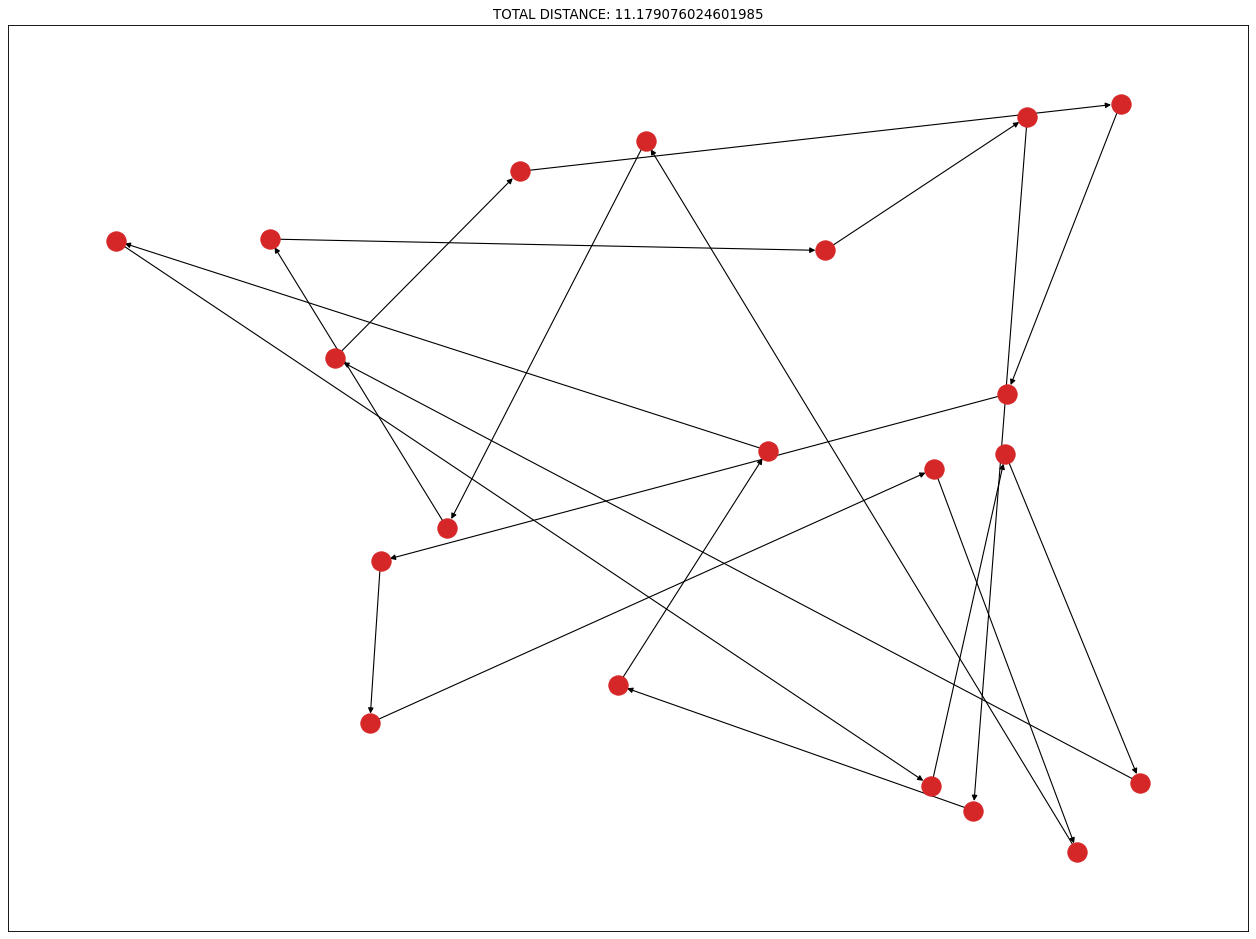

SOLUTION IN INTERATION NUMBER: 1


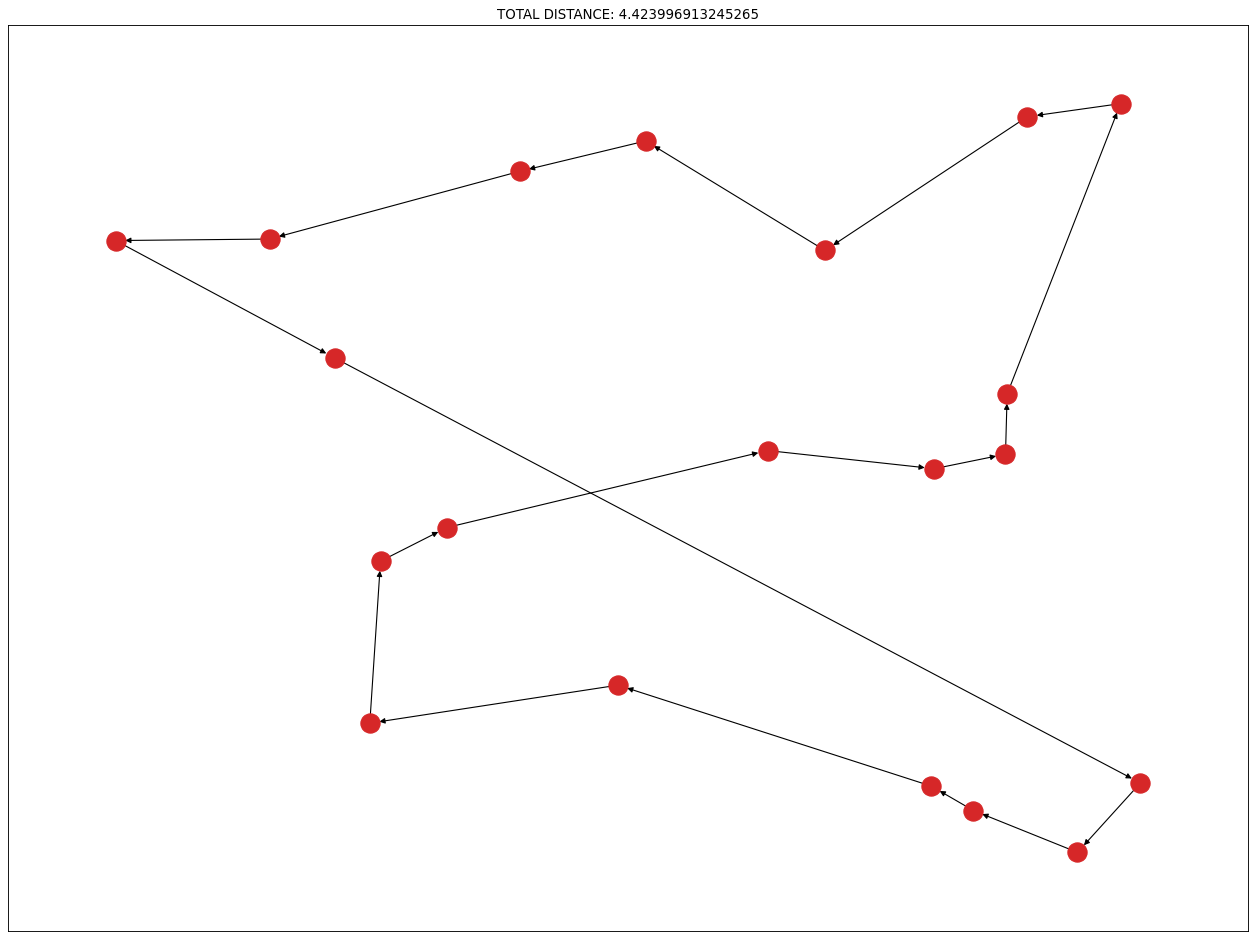

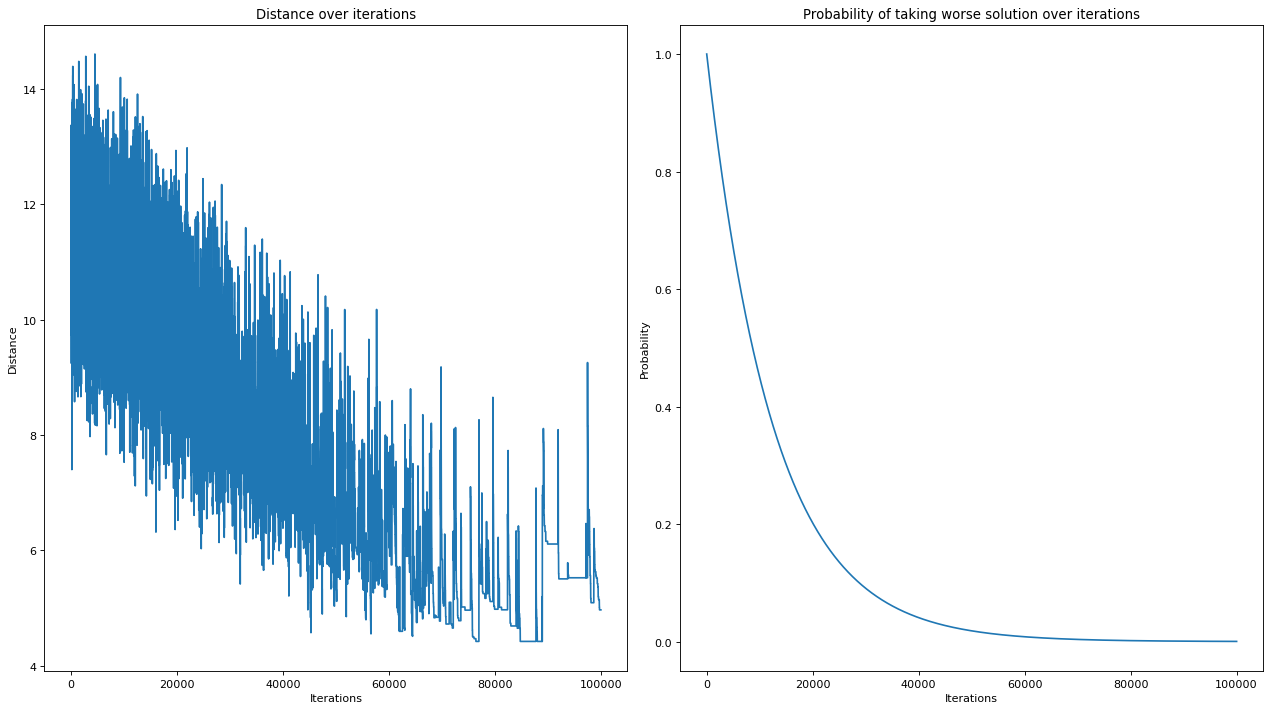

In [15]:
run_tsp(1, {'n': 20}, {'max_iterations': 10**5})

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 40 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

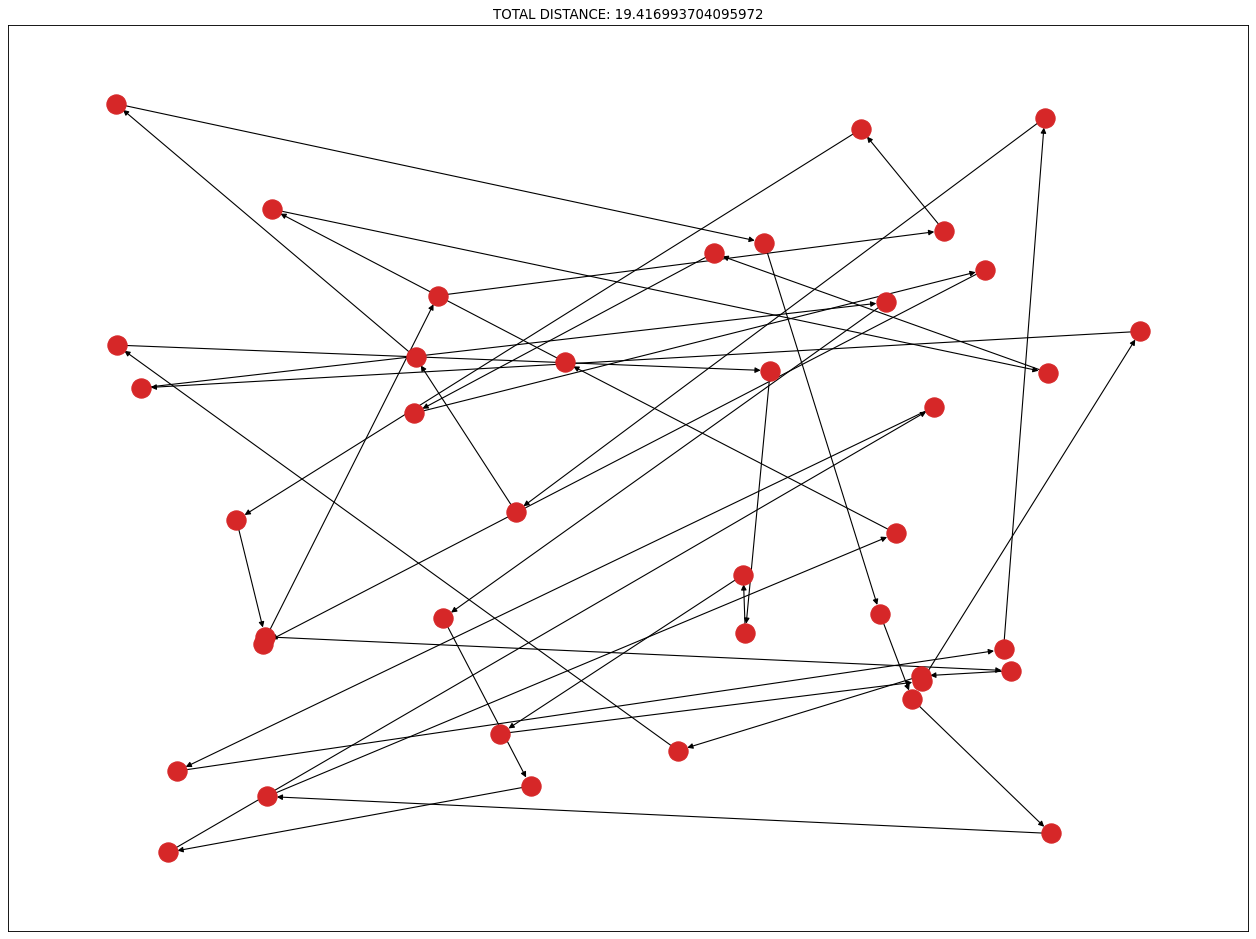

SOLUTION IN INTERATION NUMBER: 1


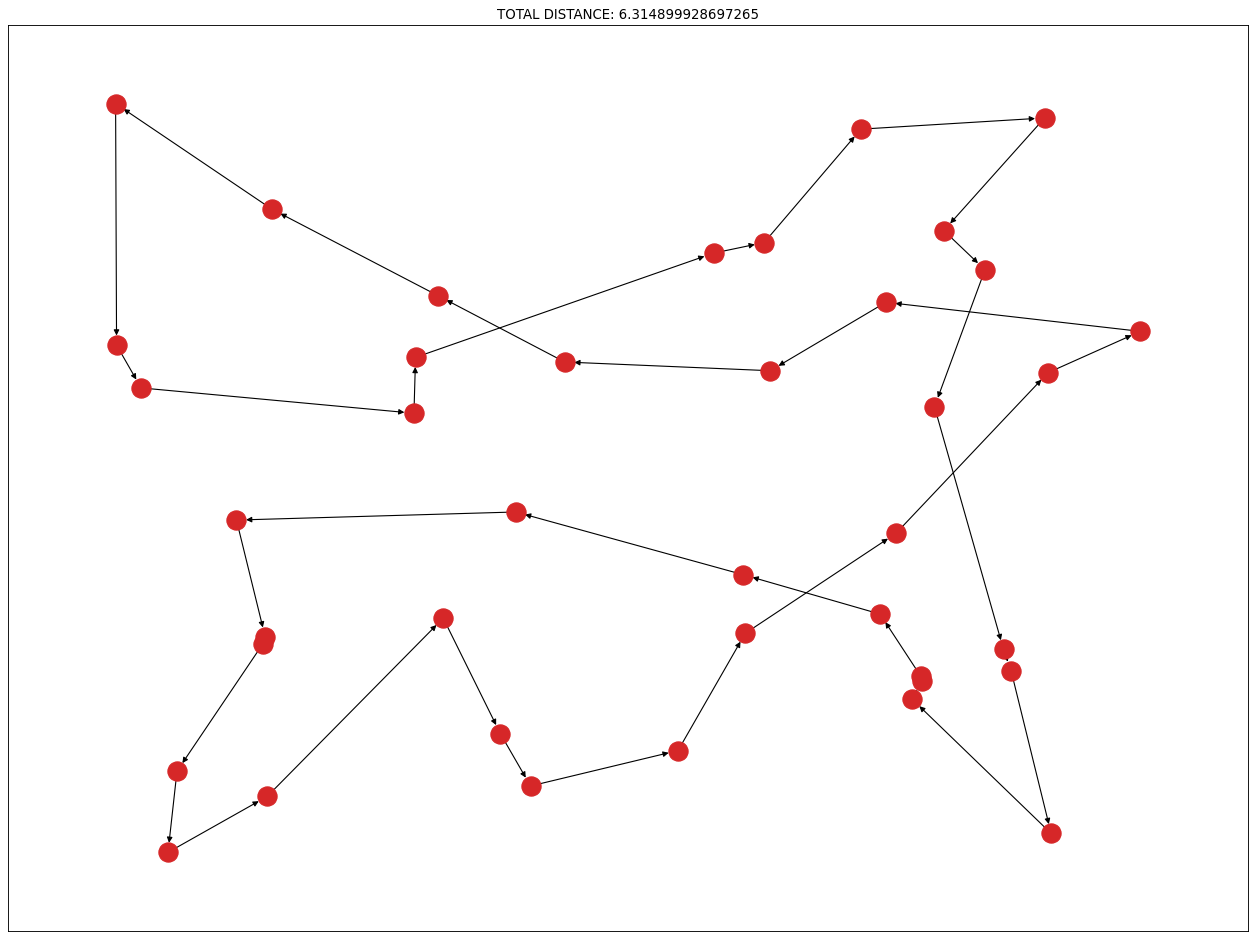

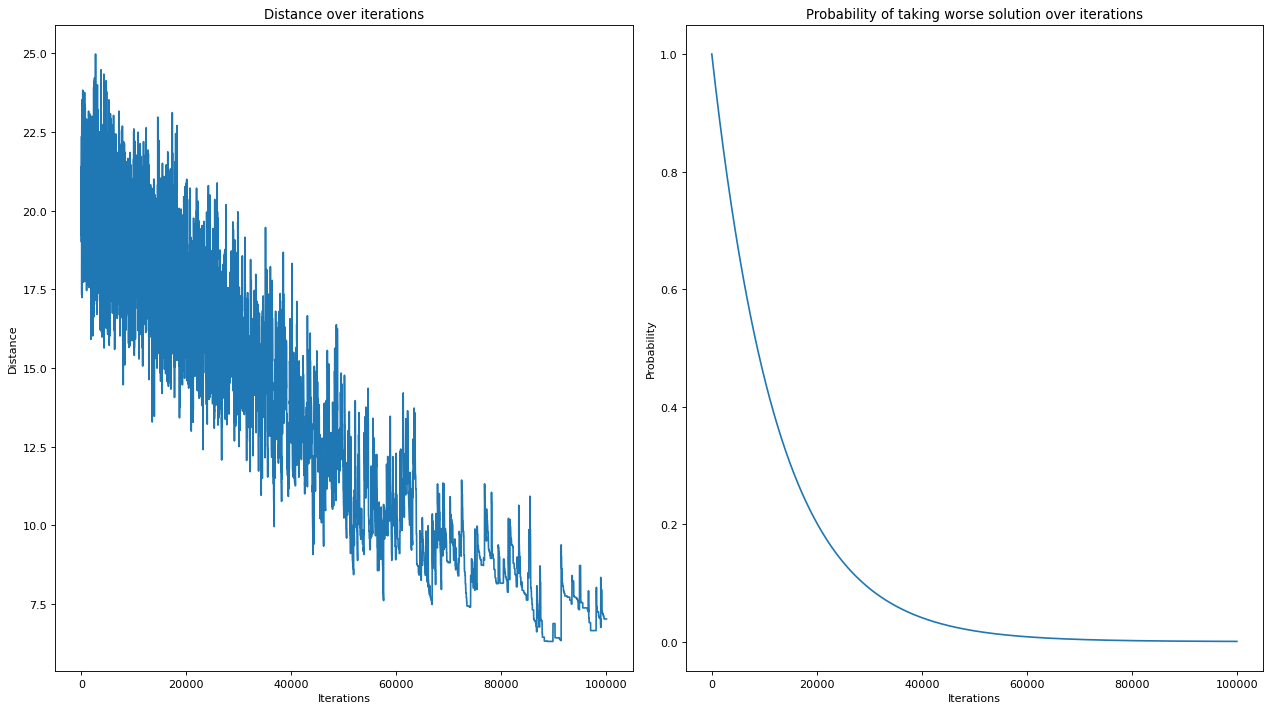

In [16]:
run_tsp(1, {'n': 40}, {'max_iterations': 10**5})

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 80 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

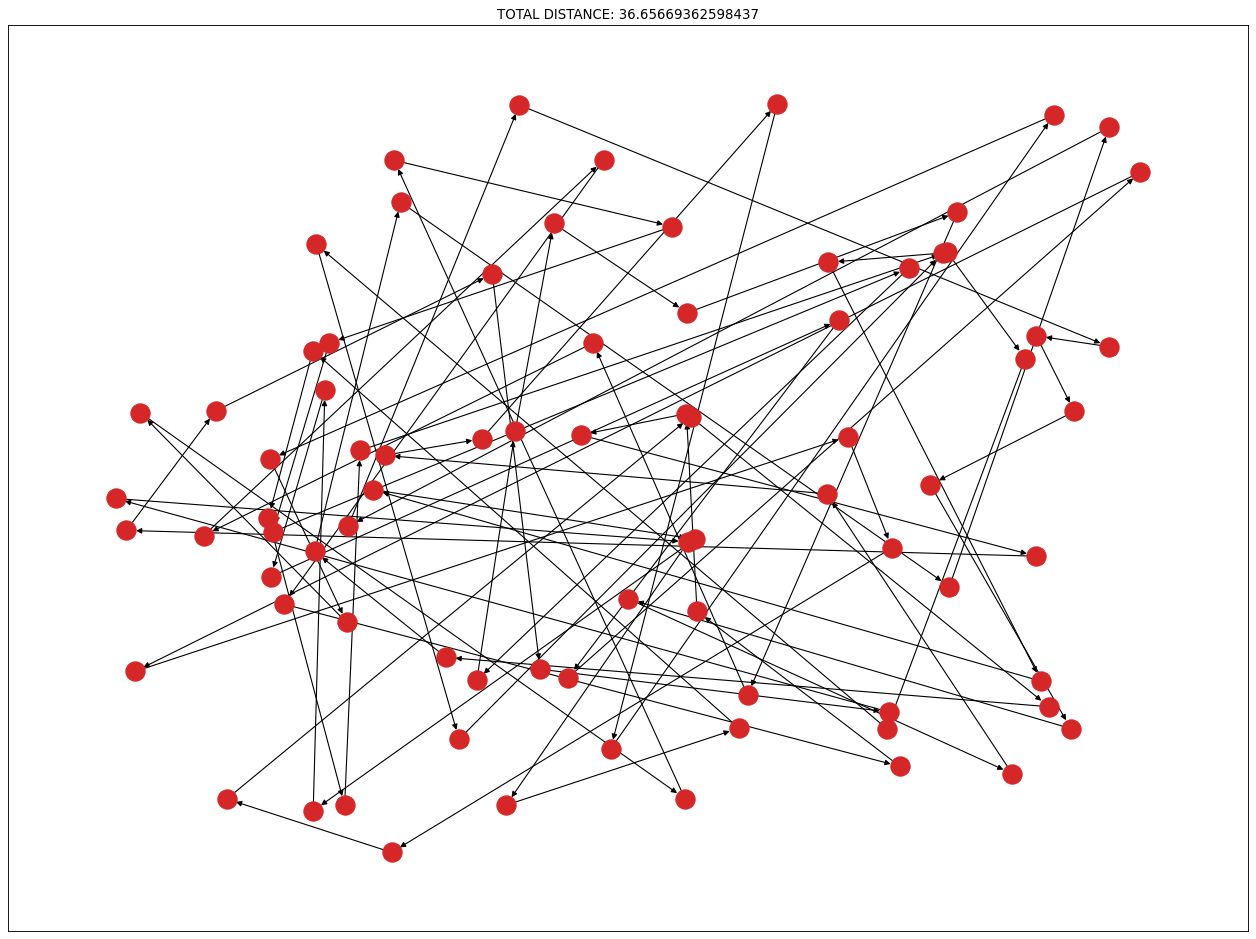

SOLUTION IN INTERATION NUMBER: 1


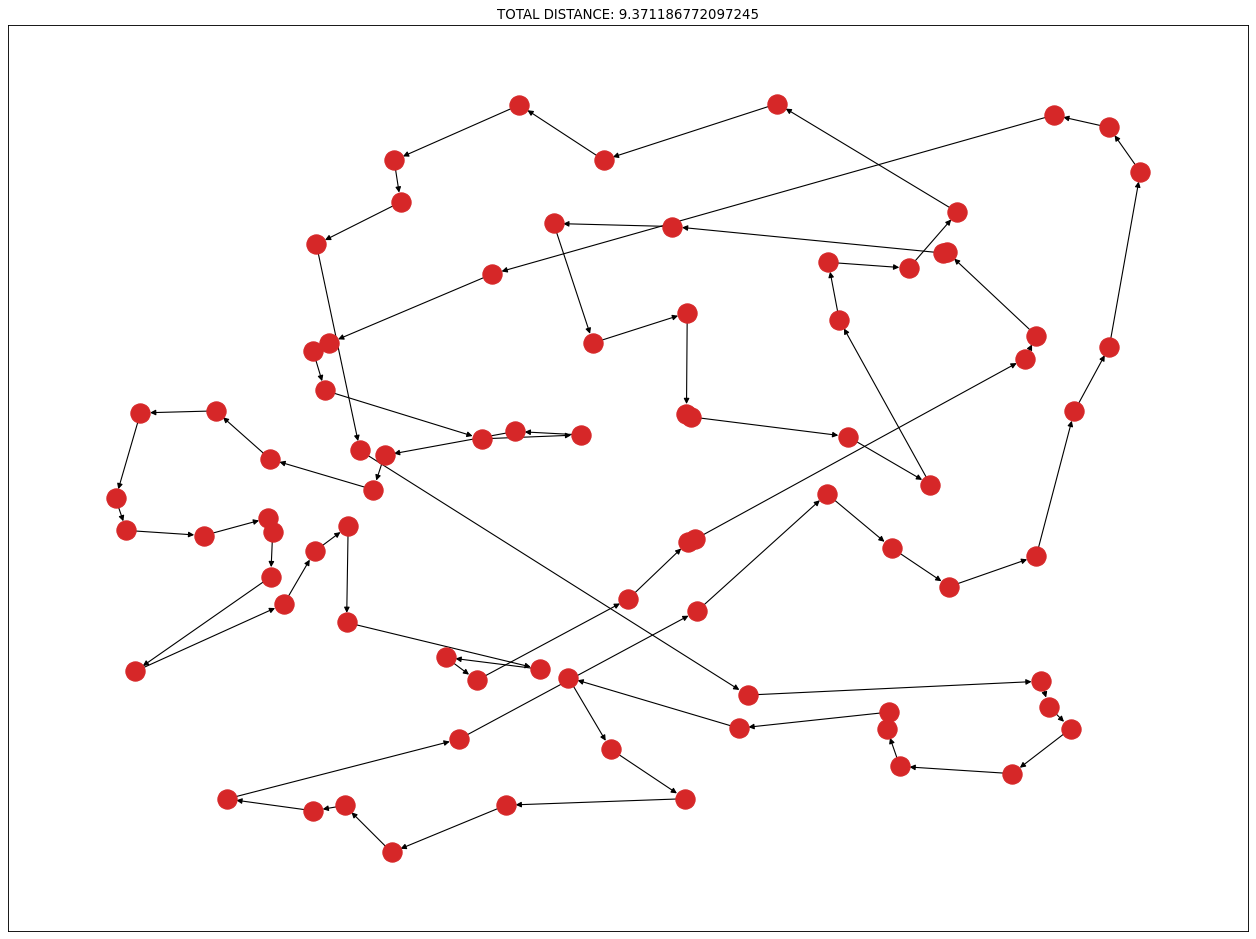

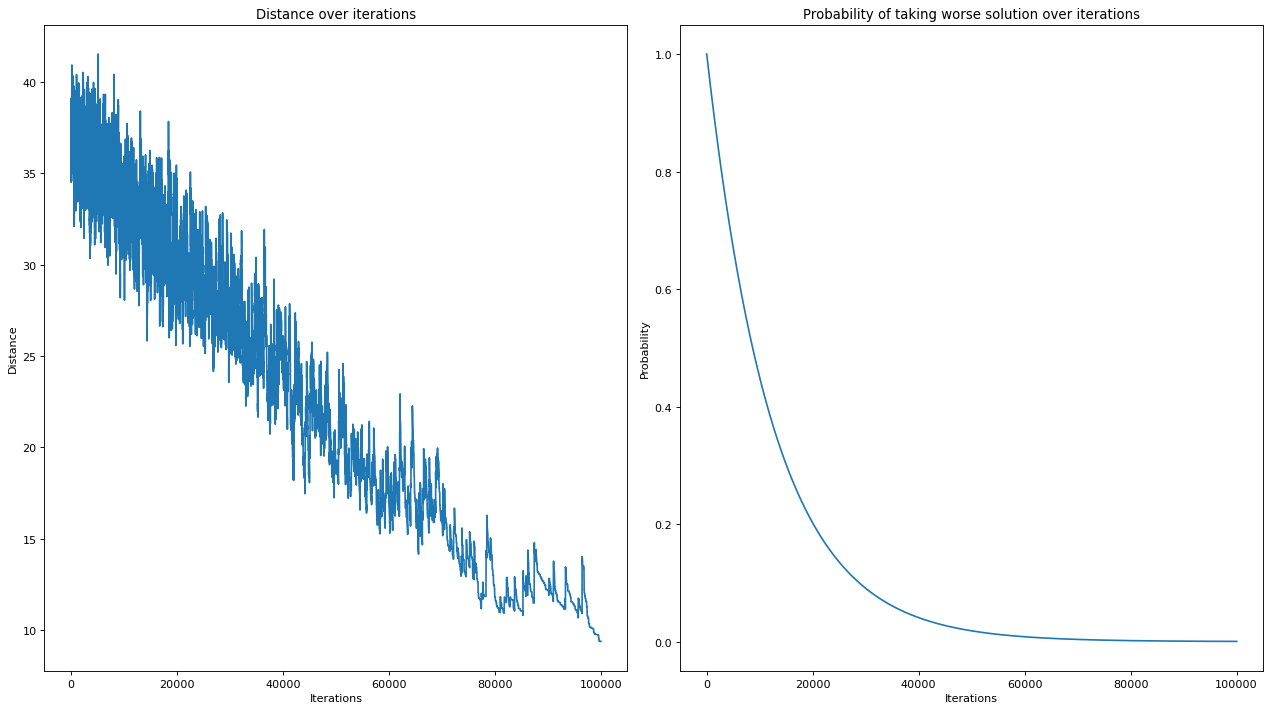

In [17]:
run_tsp(1, {'n': 80}, {'max_iterations': 10**5})

#### Dziewięć odseparowanych grup punktów
Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 27 punktów -> 9 grup po 3 punkty
4. $e^{-x}$ jako funkcja prawdopodobieństwa

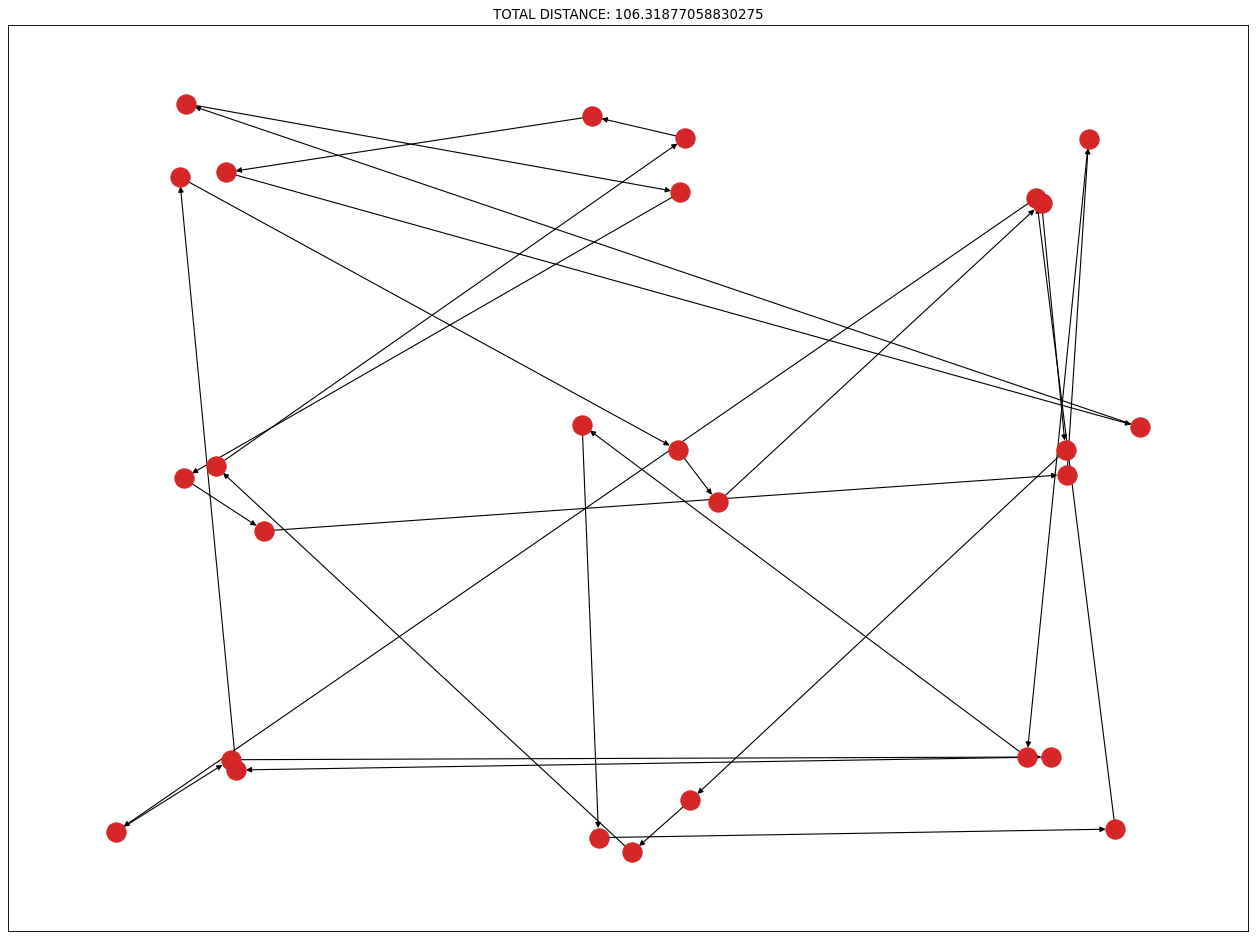

SOLUTION IN INTERATION NUMBER: 1


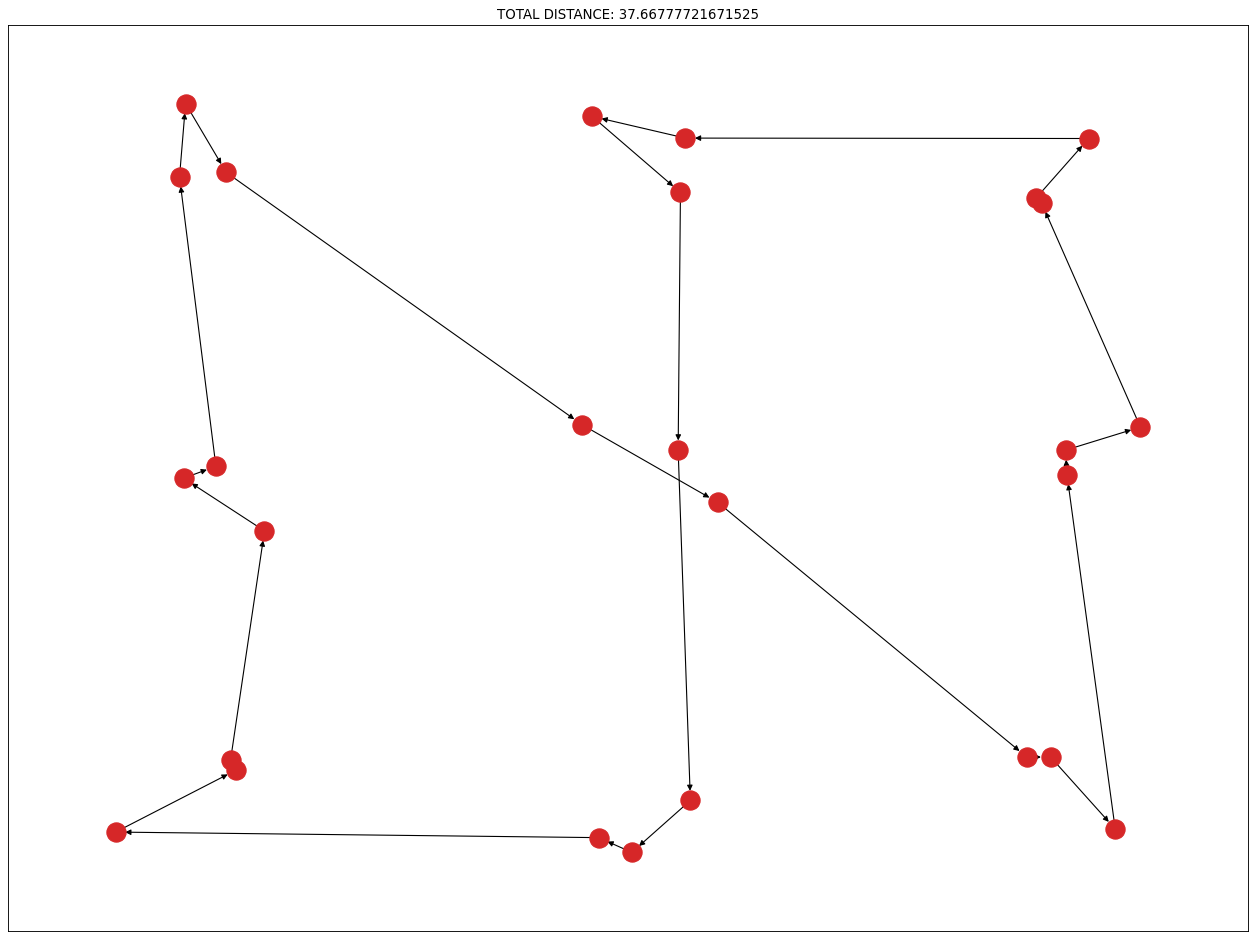

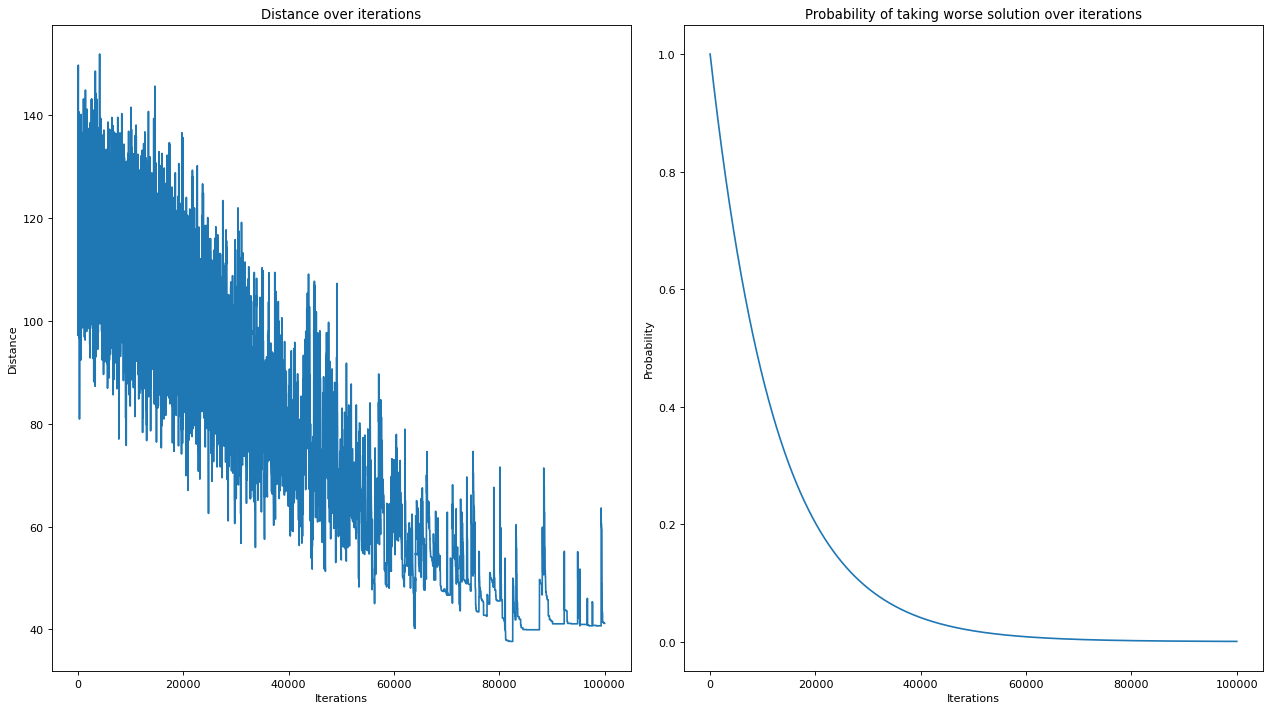

In [18]:
run_tsp(1, {'n': 27, 'groups': 9}, {'max_iterations': 10**5}, generation=generate_groups)

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 45 punktów -> 9 grup po 5 punkty
4. $e^{-x}$ jako funkcja prawdopodobieństwa

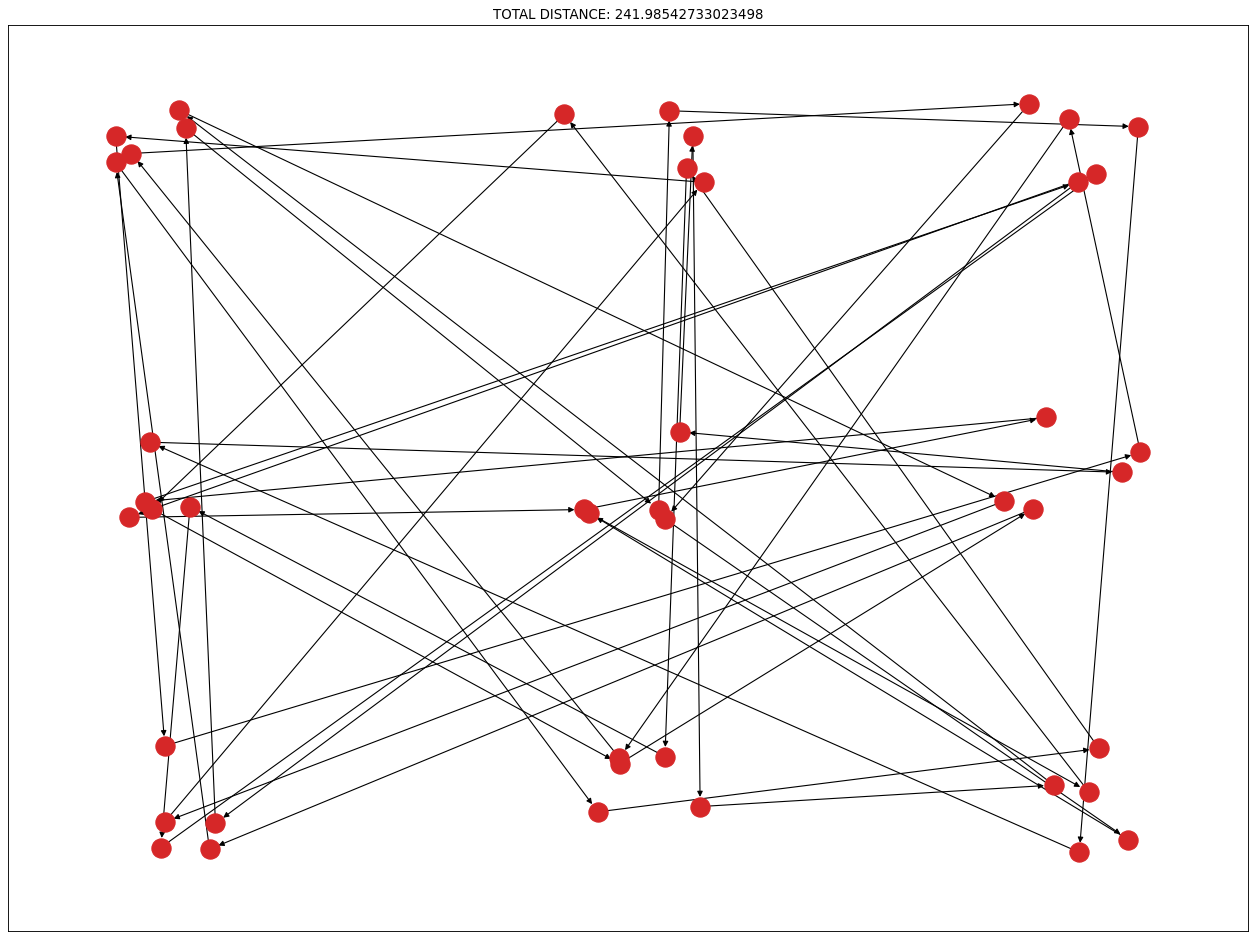

SOLUTION IN INTERATION NUMBER: 1


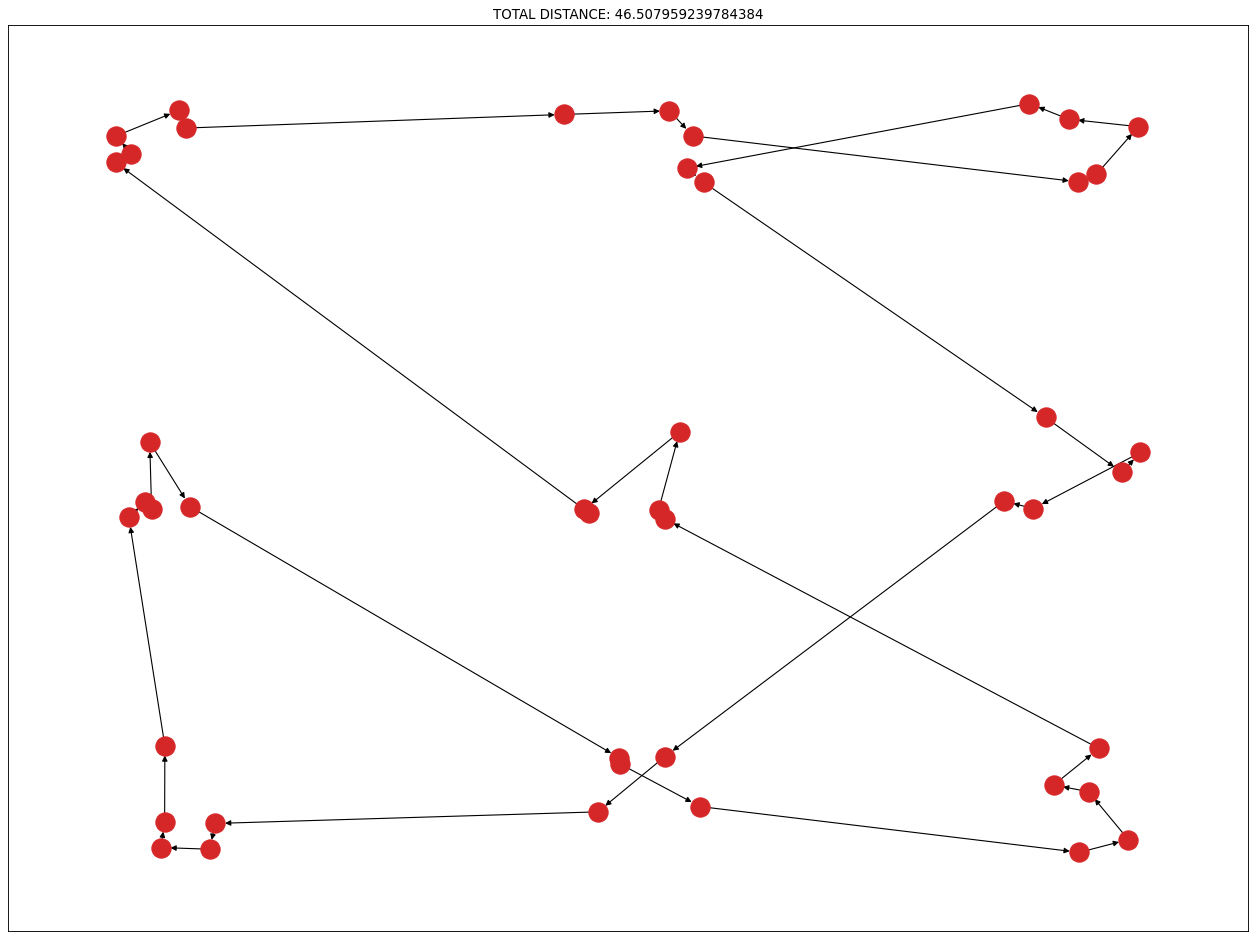

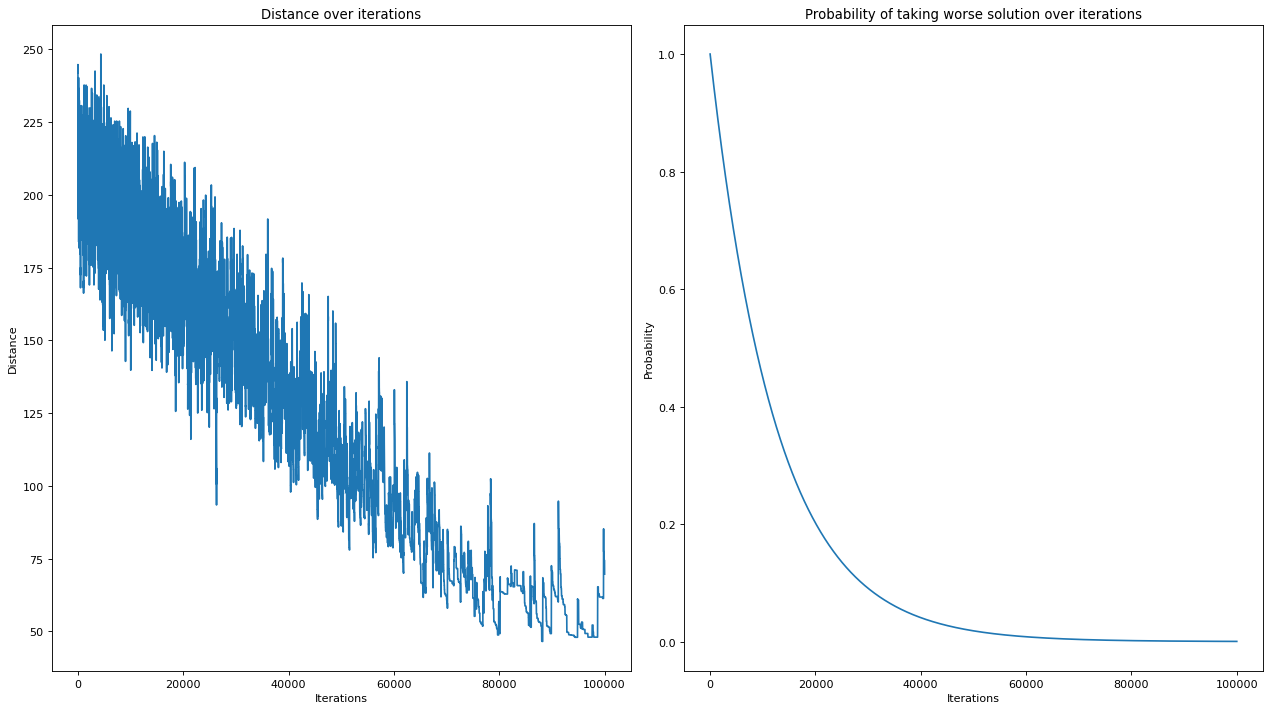

In [19]:
run_tsp(1, {'n': 45, 'groups': 9}, {'max_iterations': 10**5}, generation=generate_groups)

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 90 punktów -> 9 grup po 10 punkty
4. $e^{-x}$ jako funkcja prawdopodobieństwa

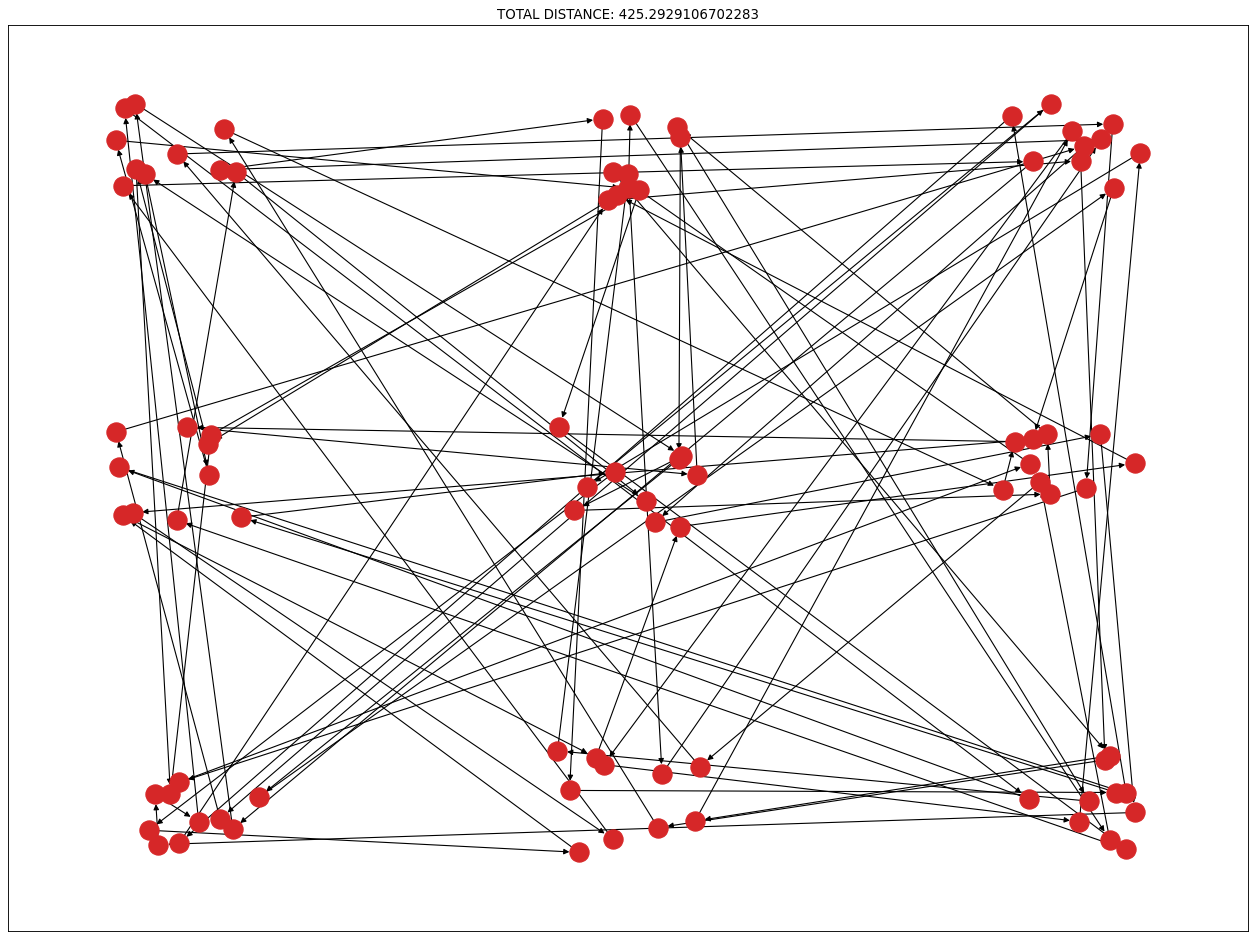

SOLUTION IN INTERATION NUMBER: 1


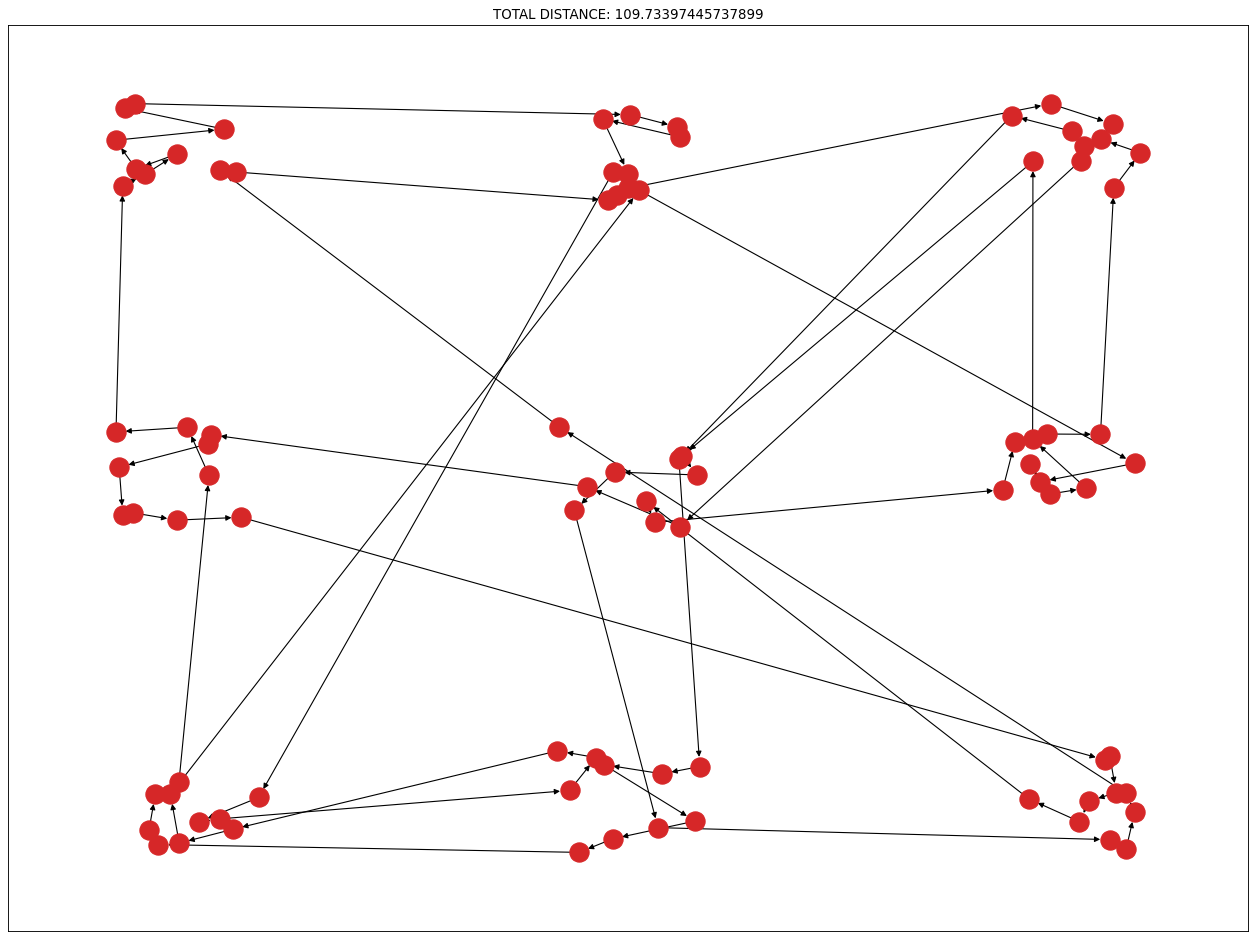

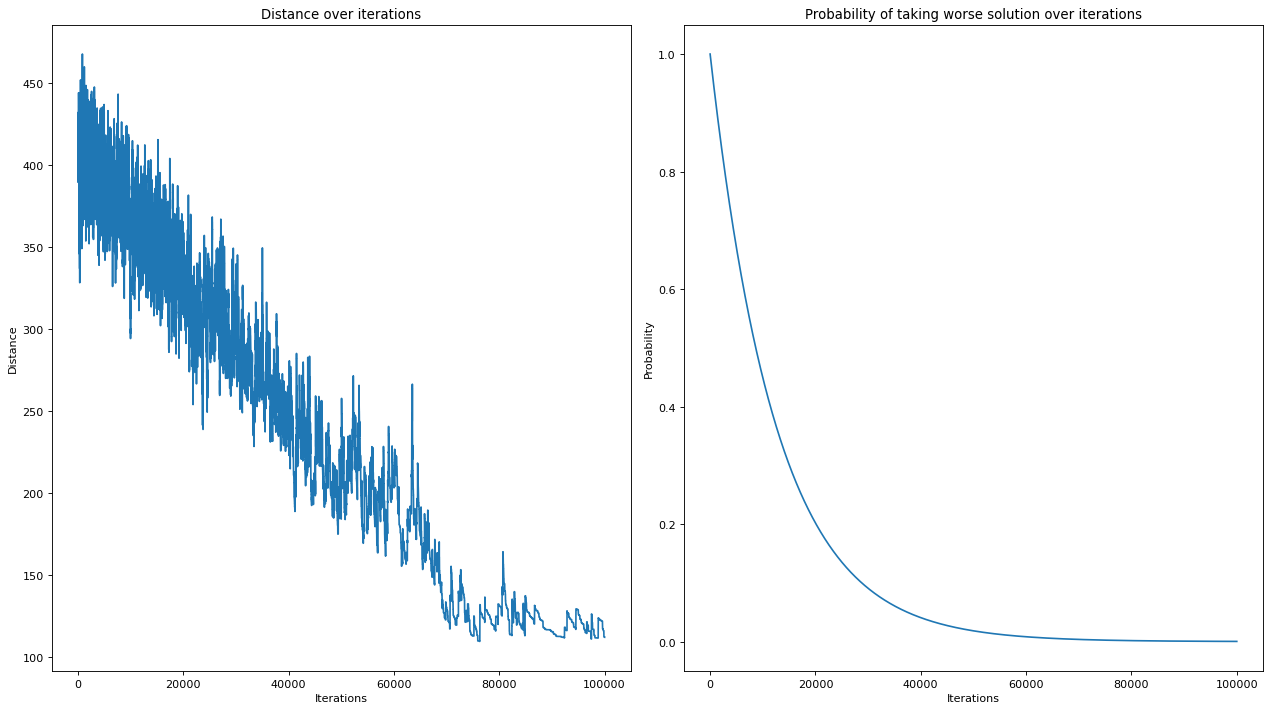

In [20]:
run_tsp(1, {'n': 90, 'groups': 9}, {'max_iterations': 10**5}, generation=generate_groups)

#### Rozkład normalny
Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 20 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

Wnioski:
1. Algorytm działa poprawnie dla małych n. Dla liczby wierzchołków ~> 20 wynik jest dobry, o wiele lepszy niż początkowy, ale nie jest optymalny (najłatwiej zaobserowwać to na grafach typu 9 grup)
2. W algorytmach sochastycznych należy zapamiętywać najlepsze rozwiązanie. Na niektórych wykresach `Distance over iterations` widać jak algorytm zmienia wynik na gorszy, lecz później nie daje rady do niego się zbliżyć (np 9 grup po 10 wierzchołków)
3. Algorytm należy uruchomić kilka razy (np. 5) i użyć najlepszego rozwiązania. Algorytmy sochastyczne potrafią 'zablokować się' w minimum lokalnym, przez co zwrócony wynik może być daleki od optymalnego


### 1.2  Wpływ sposobu generacji sąsiedniego stanu oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji.

Sprawdzenie wpływu tych parametrów będzie testowane dla takich samych danych:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 100 punktów o rozkładzie jednostajnym

Analizowane zostanie zachowanie algorytmu przy:
1. `consecutive swap` vs `arbitrary swap` (dwa losowe punkty vs losowy punkt i jego następnik)
2. liniowia vs eksponencjalna funkcja prawdopodobieństwa


#### Eksponencjalna funkcja i arbitrary swap

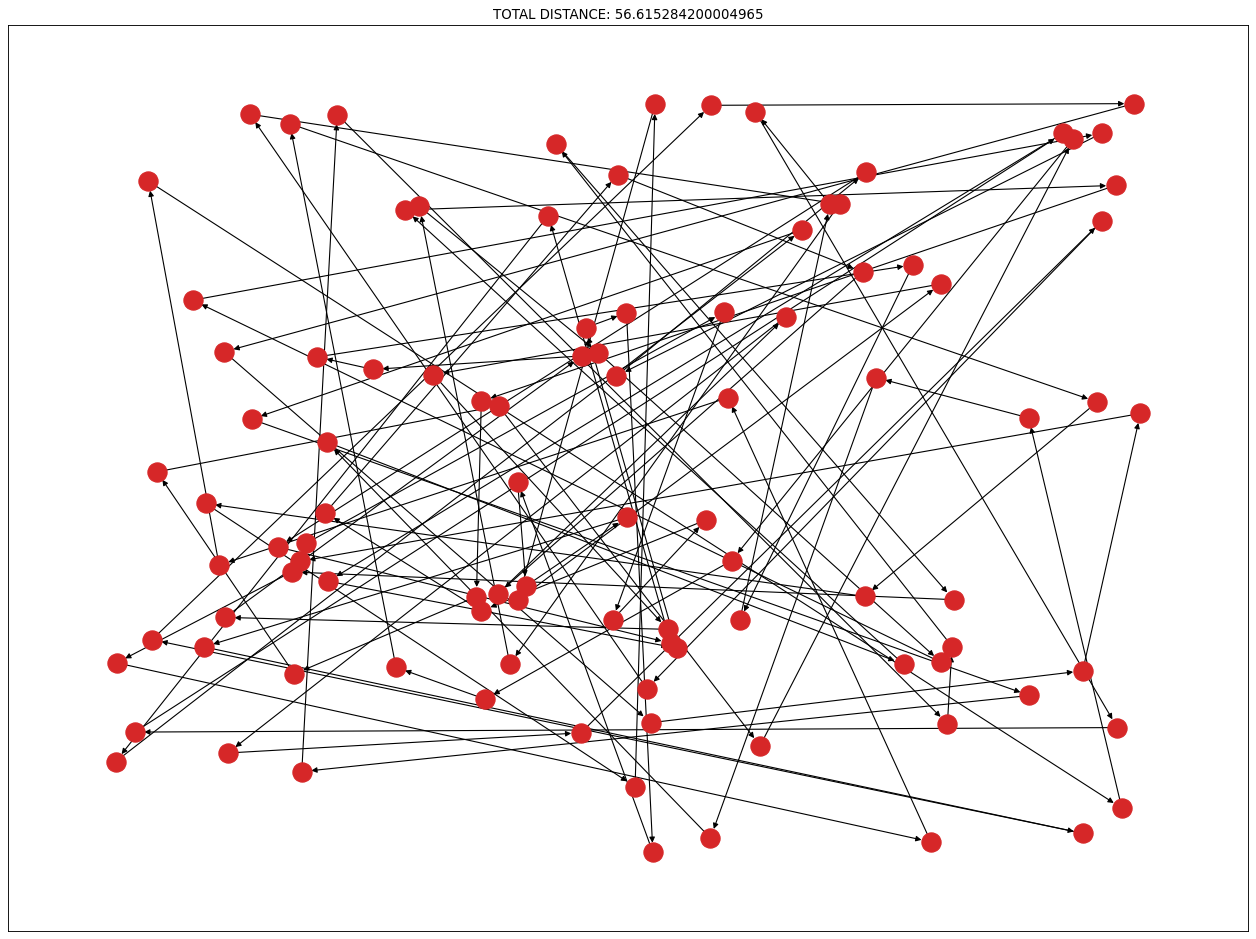

SOLUTION IN INTERATION NUMBER: 1


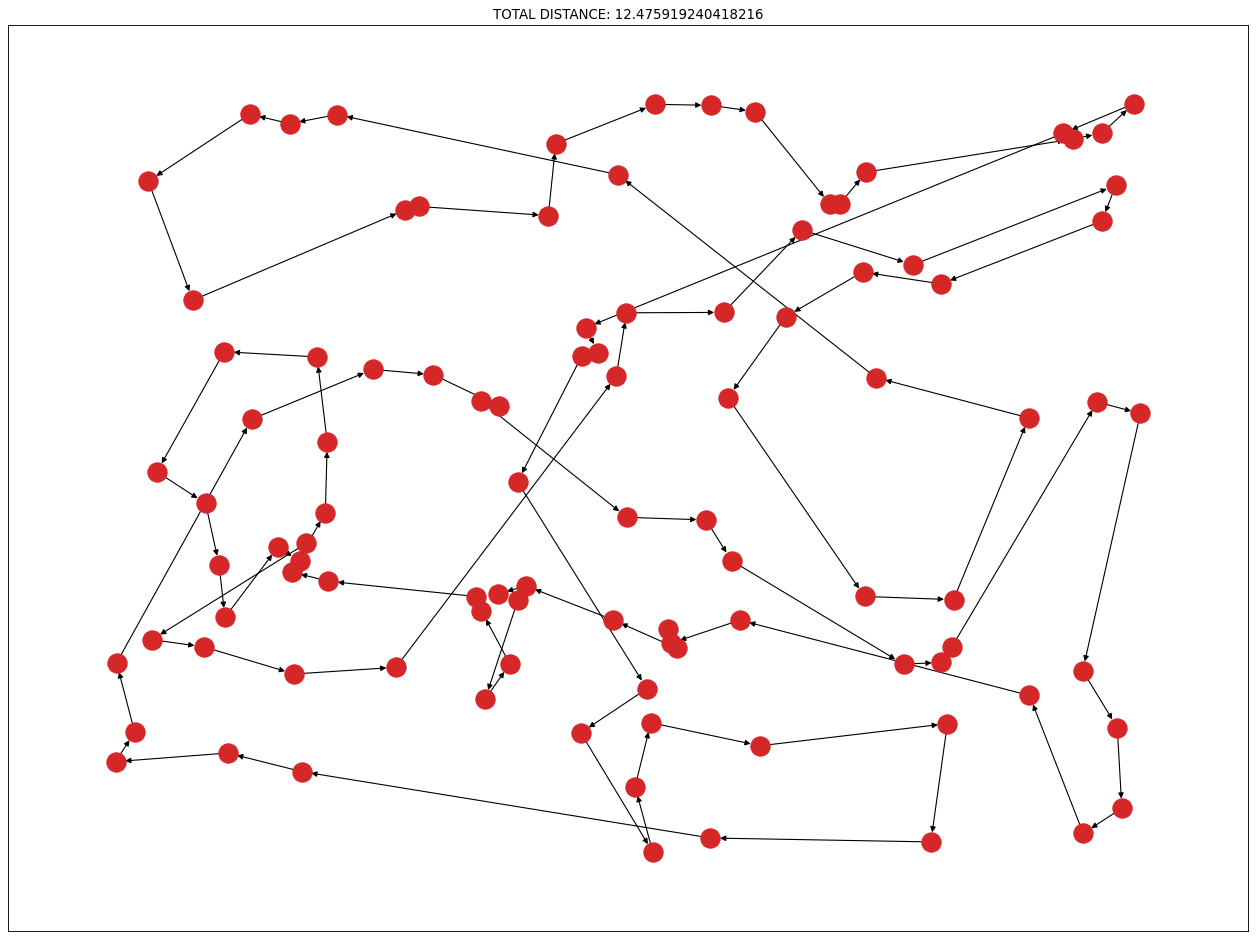

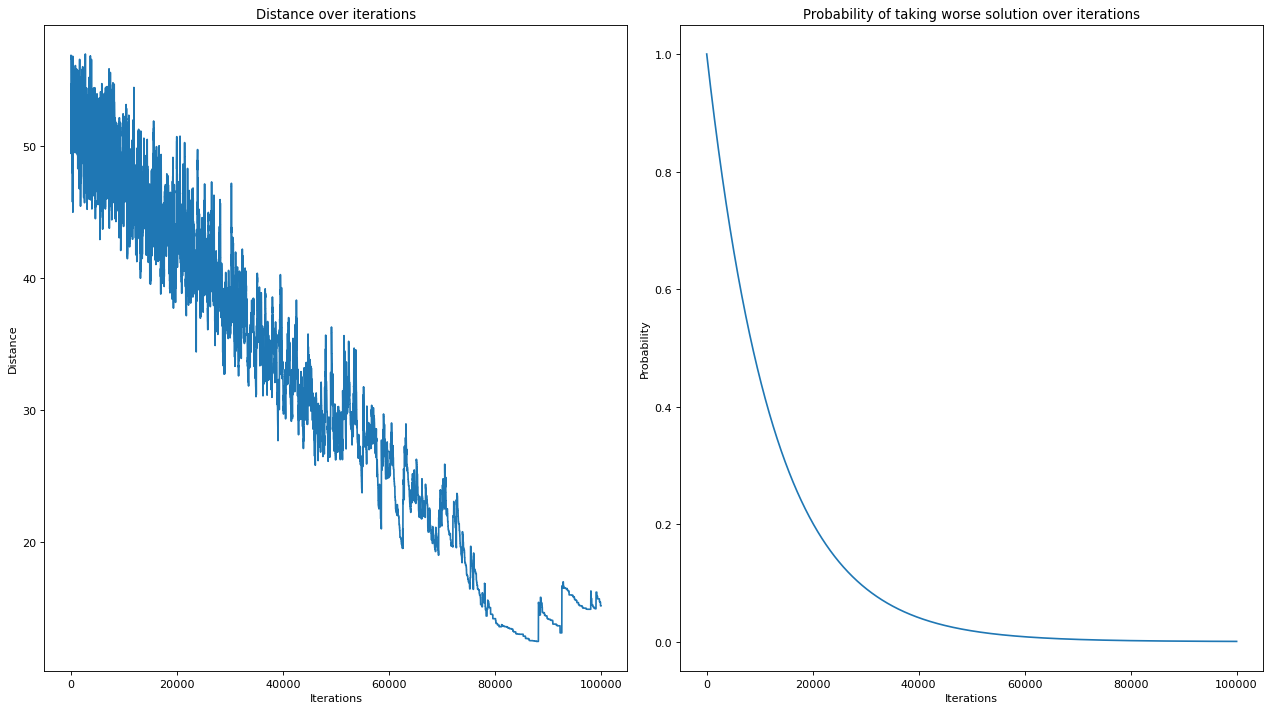

In [21]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=100)

#### Liniowa funkcja i arbitrary swap

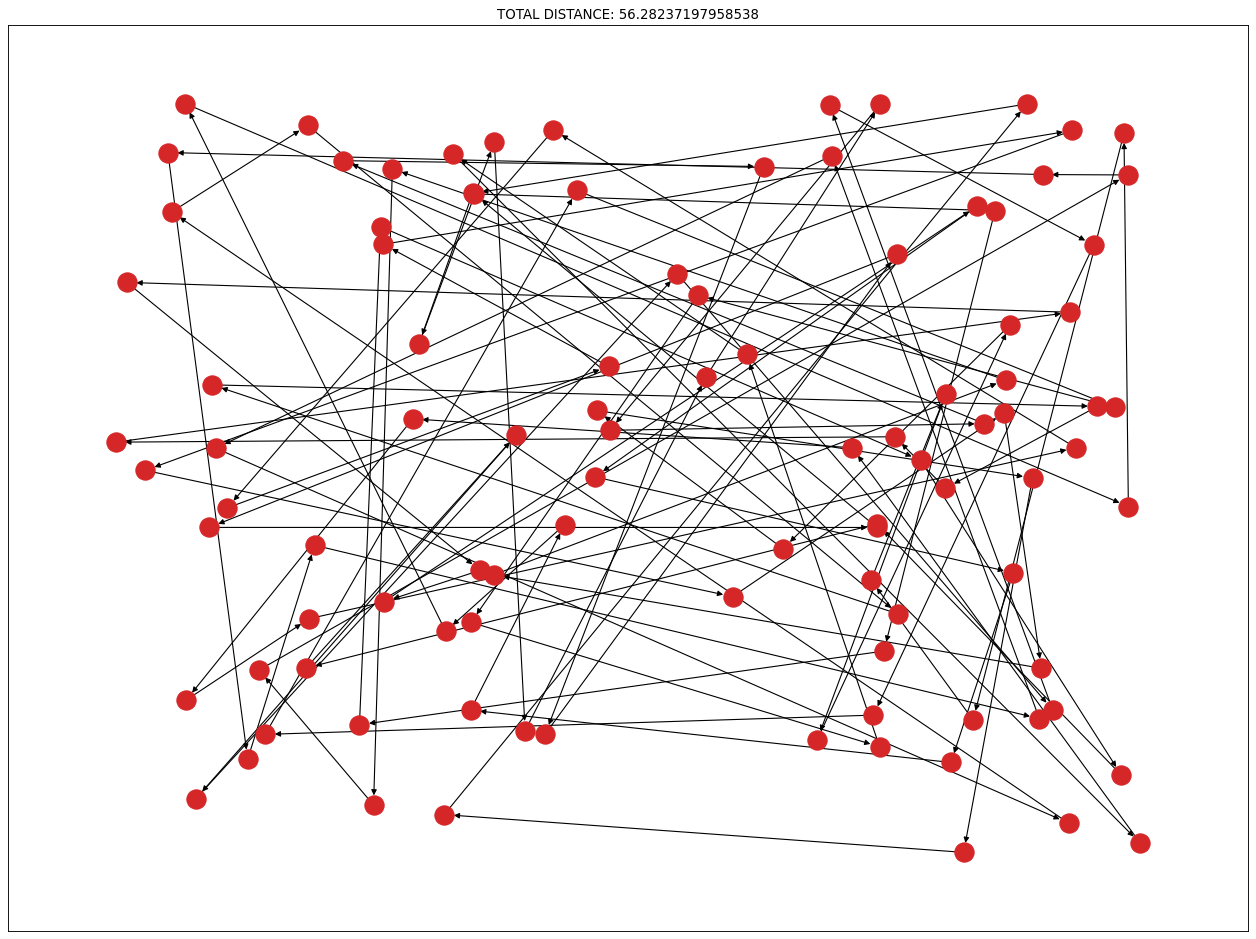

SOLUTION IN INTERATION NUMBER: 1


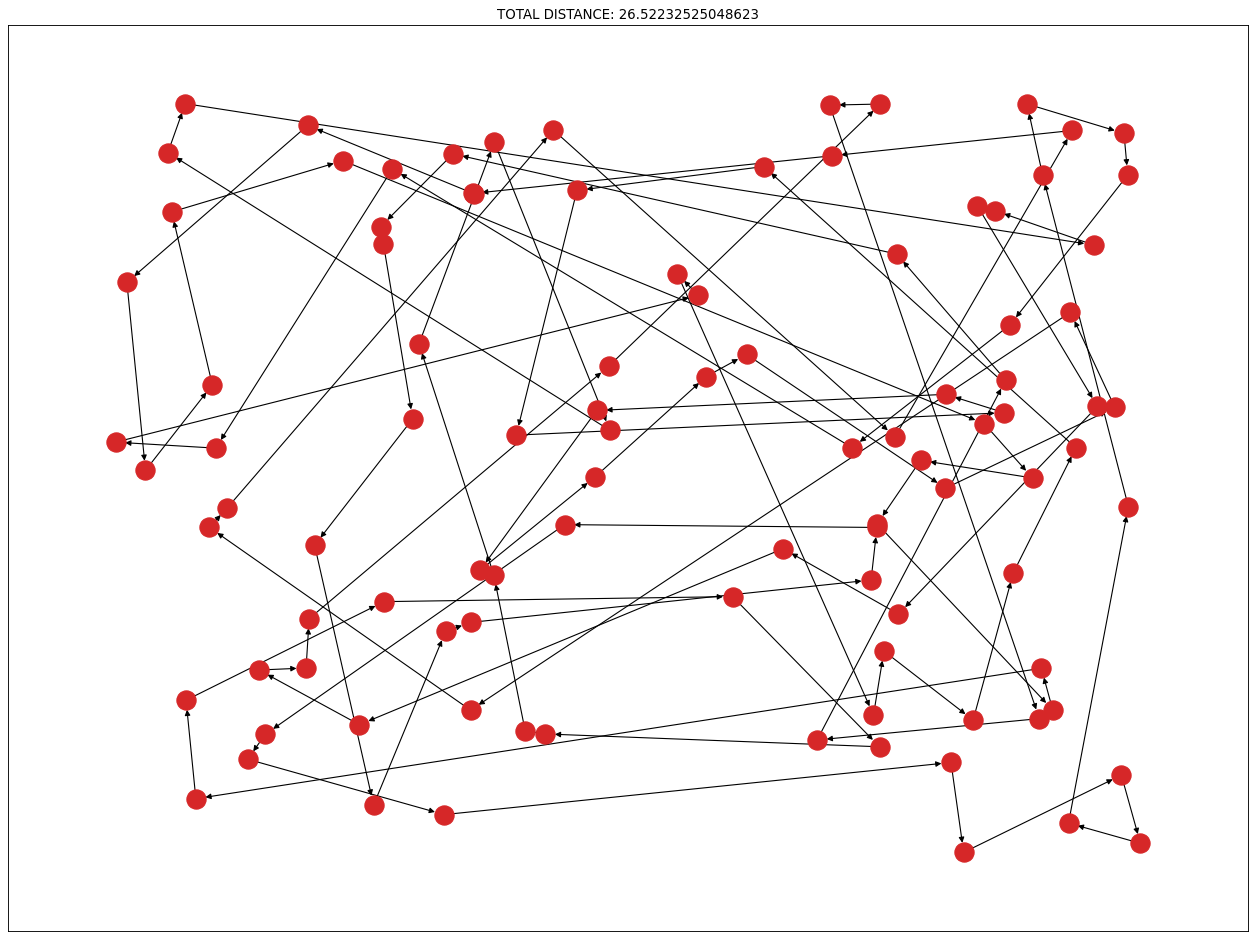

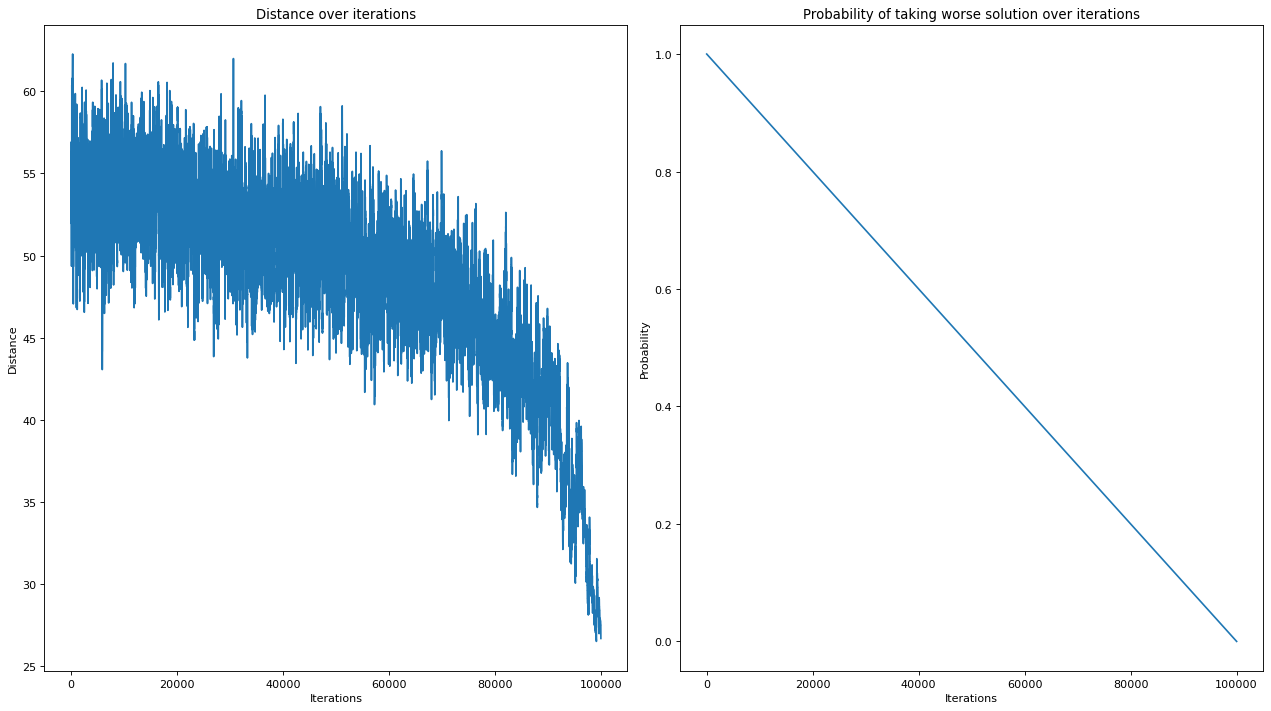

In [22]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, linear=True)

#### Eksponencjalna funkcja i consecutive swap

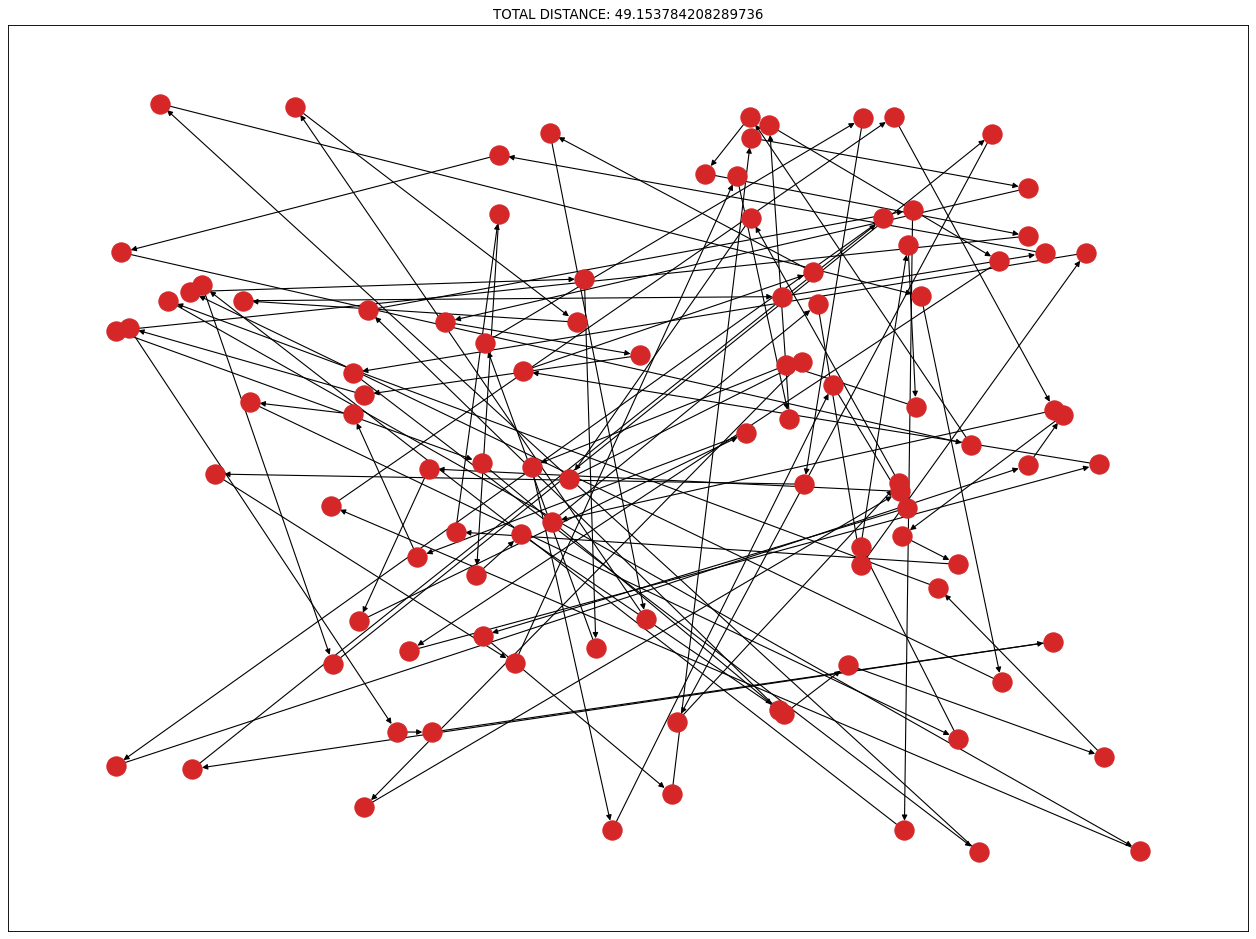

SOLUTION IN INTERATION NUMBER: 1


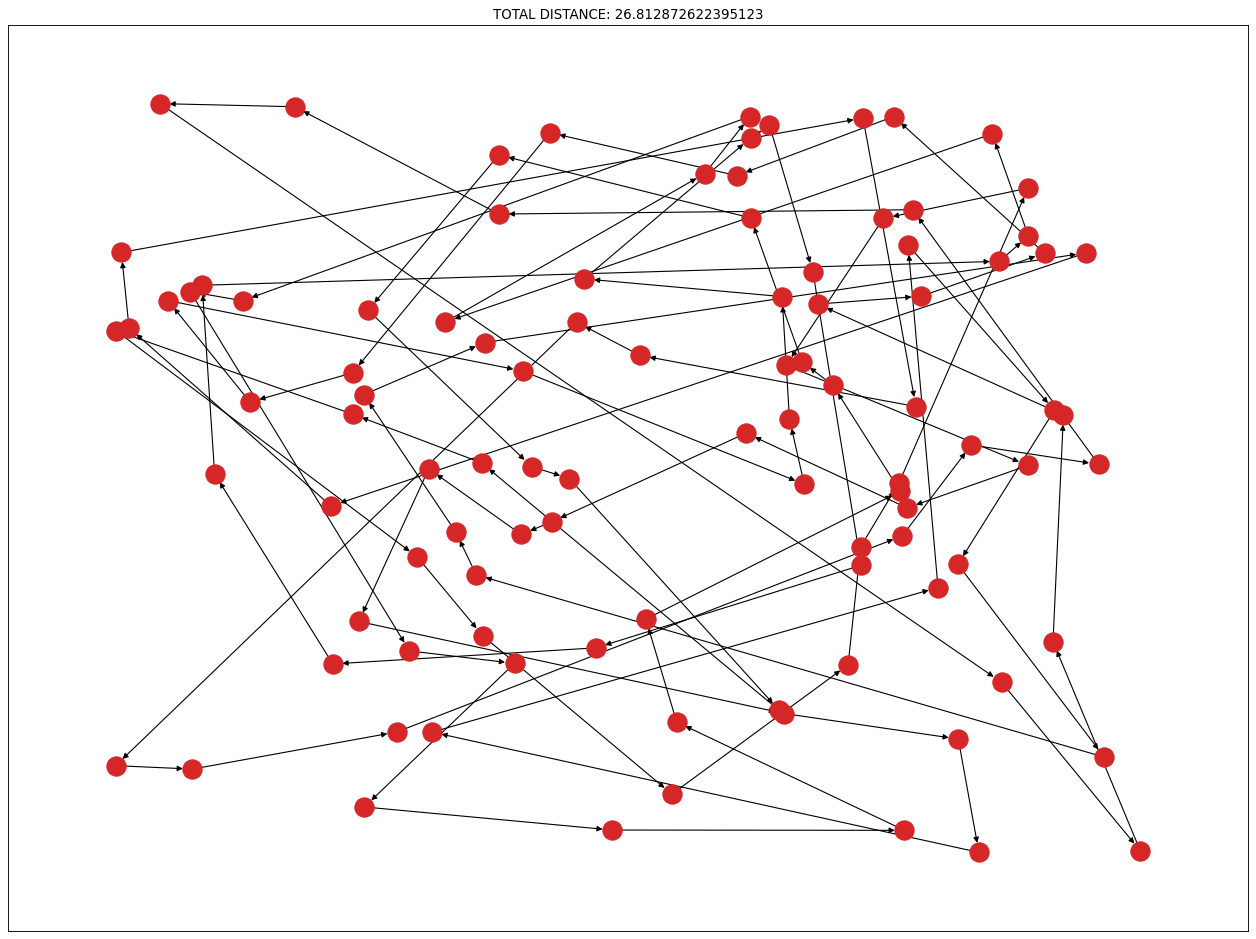

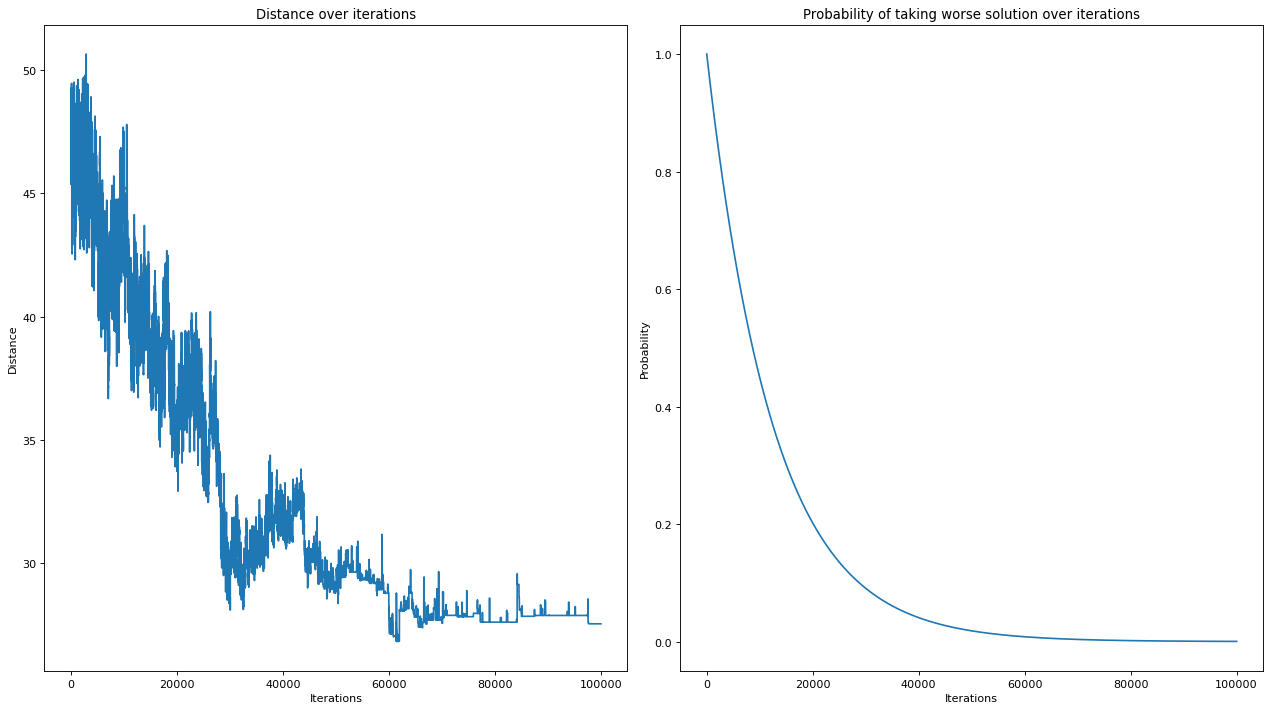

In [23]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=20, consecutive_swap=True)

#### Liniowa funkcja i consecutive swap

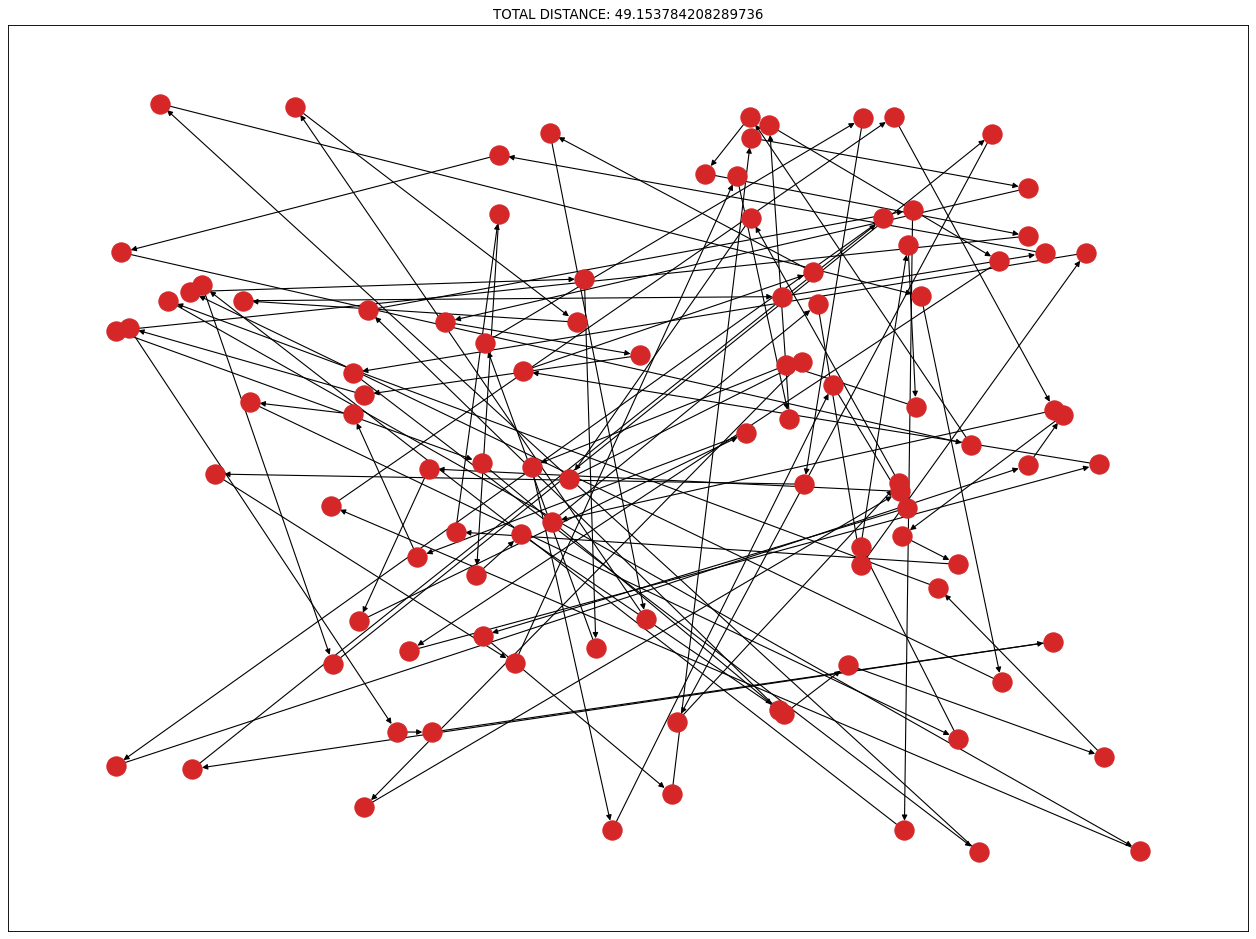

SOLUTION IN INTERATION NUMBER: 1


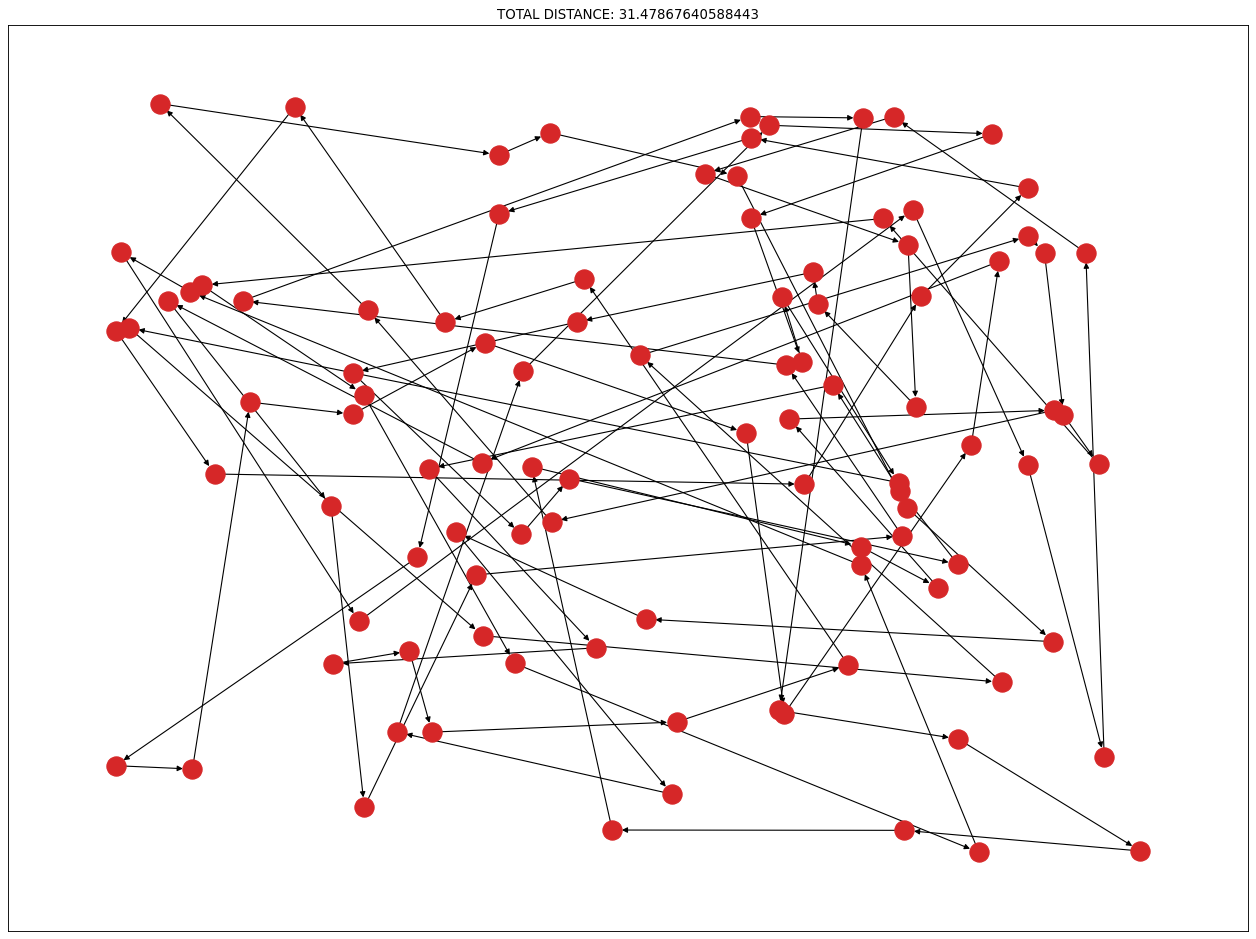

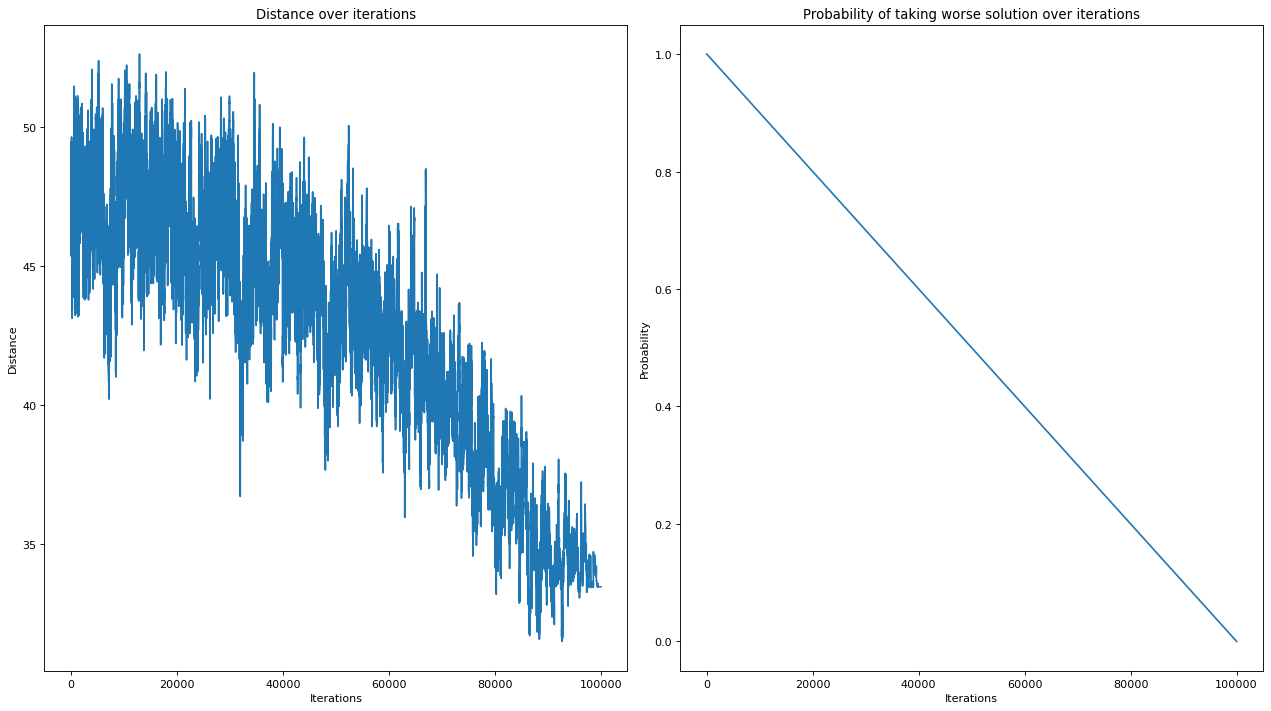

In [24]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5} ,seed=20, linear=True, consecutive_swap=True)

Wnioski:
1. Funkcja liniowa daje zdecydowanie gorsze rezultaty niż eksponencjalna (w eksponencjalnej o wiele szybciej ogarniczamy możliwość wybrania gorszego rozwiązania)
2. `Consecutive swap` jest gorsze niż `arbitrary swap`. Widać to wyraźnie porównując 'taktyki' na tle funkcji eksponencjalnej oraz liniowej. W przypadku funkcji liniowej zmieniony został `seed` na 20, ponieważ przy wartości równej 100 oraz `arbitrary swap` algorytm blokował się - nie potrafił wyjść z minimum lokalnego.


#### Łagodna funkcja temperatury

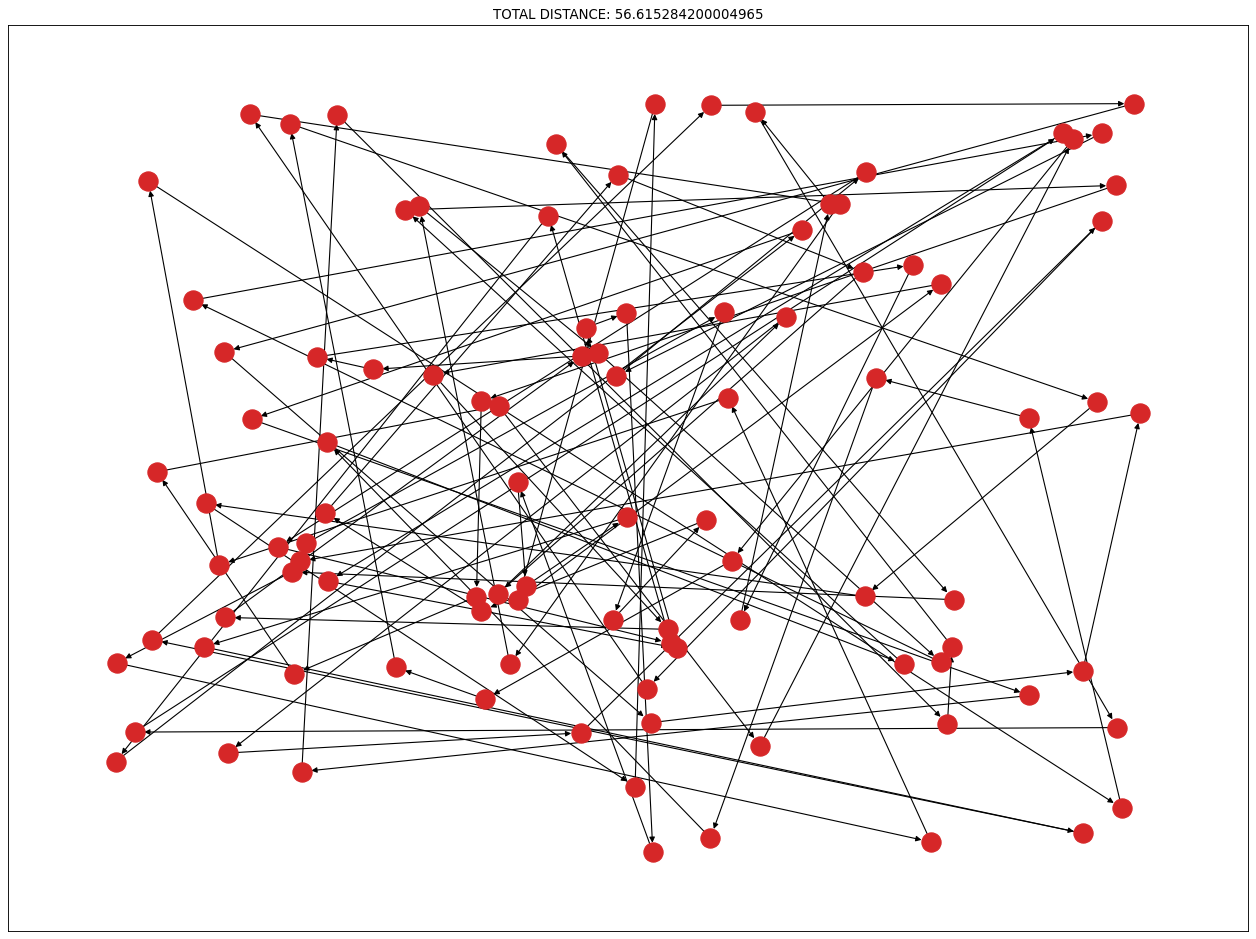

SOLUTION IN INTERATION NUMBER: 1


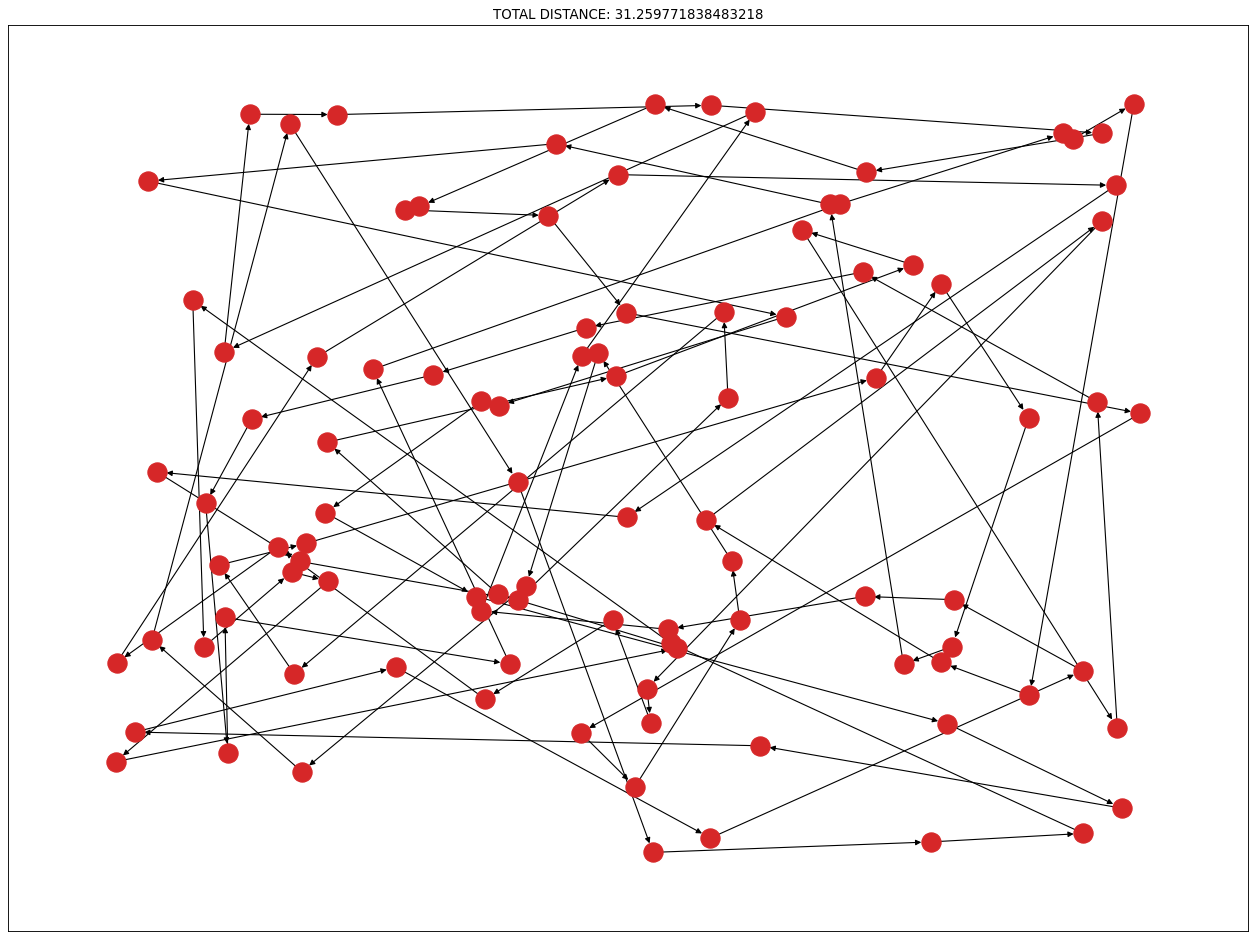

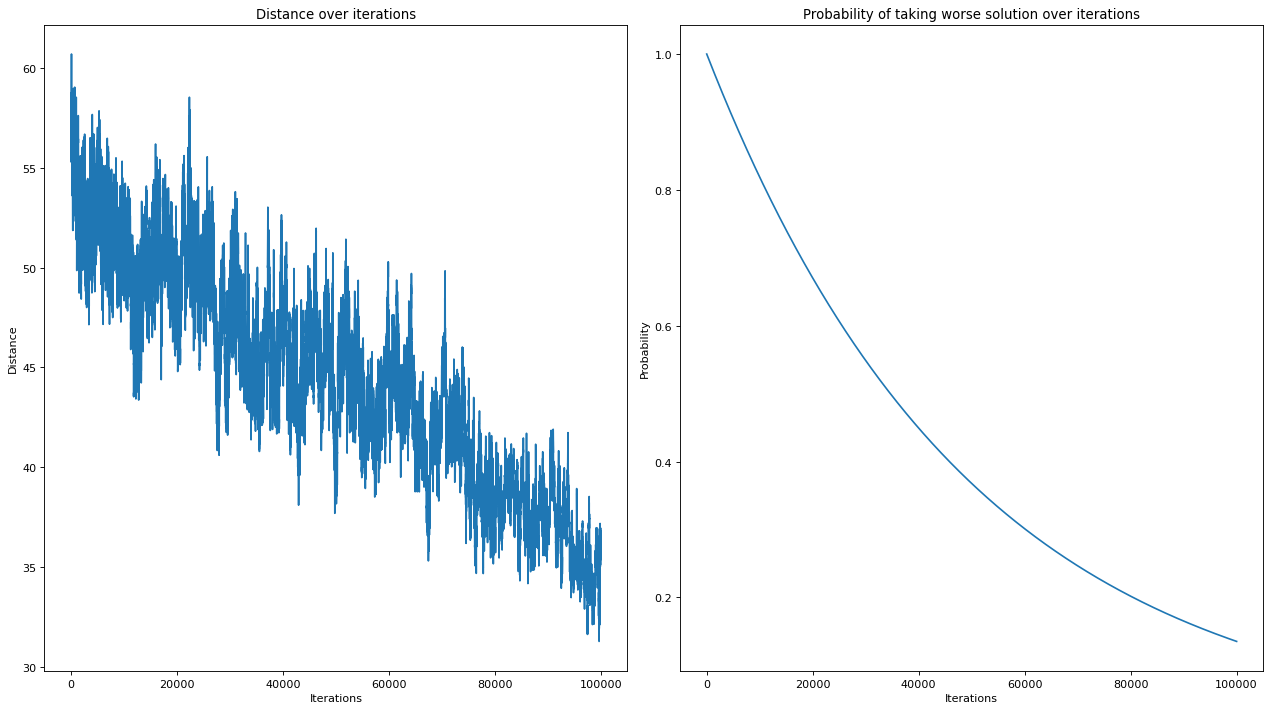

In [25]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=100, consecutive_swap=True, min_temp= -2)

#### Stroma funkcja temperatury

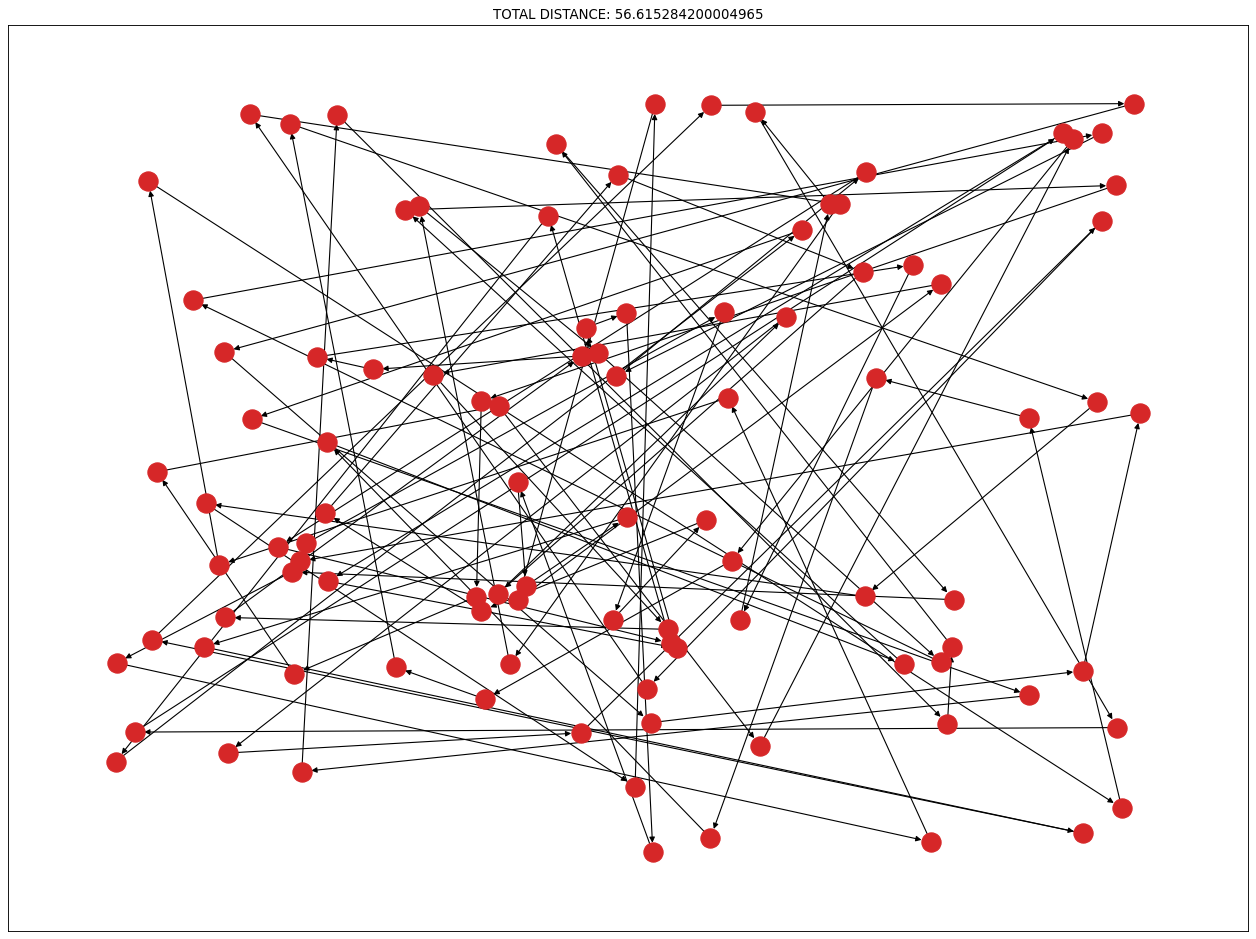

SOLUTION IN INTERATION NUMBER: 1


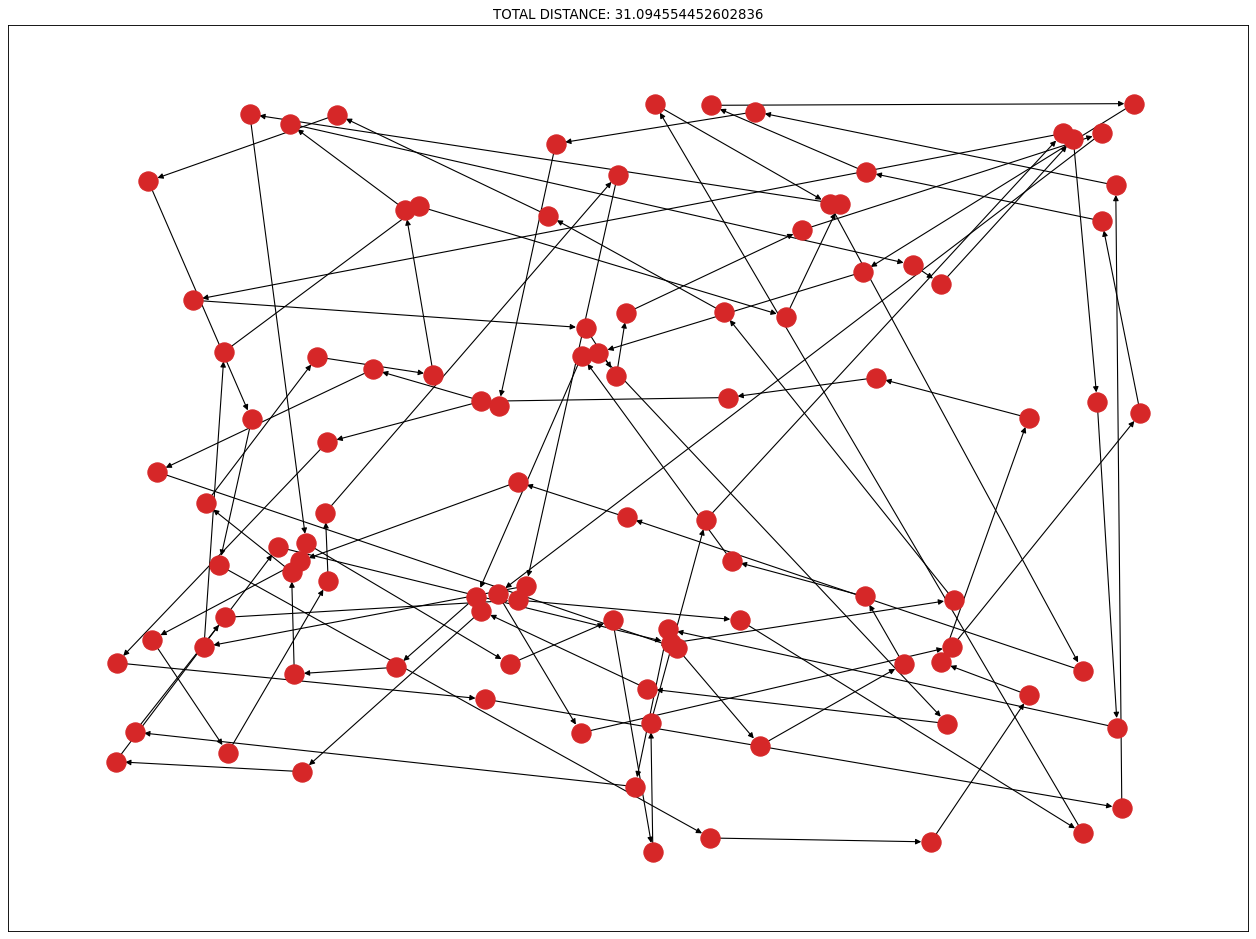

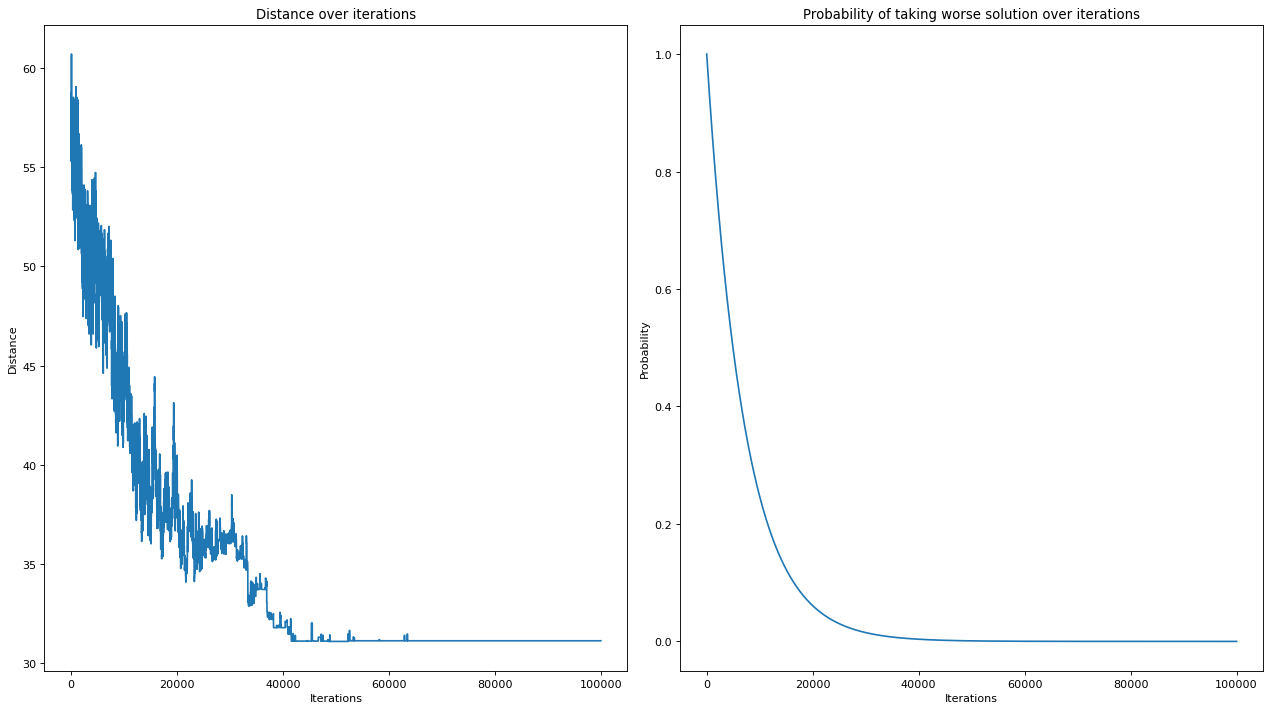

In [27]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=100, consecutive_swap=True, min_temp=-14)

Wnioski:
1. Funkcja eksponencjalna daje dobre wyniki, tylko gdy jej stromość jest odpowiednia. Taki sam przykład rozwiązany był w `1.2 Eksponencjalna funkcja i arbitrary swap`. Tamtejszy wynik jest ponad 2 razy mniejszy od powyższych! Defaultowa wartość `min_temp` to -8, właśnie wtedy stromość funkcji jest odpowiednia.
2. Zbyt stroma funkcja sprawia, że nie można wyjść z minimum lokalnego - w pewnym momencie zostaje to niemalże zablokowane
3. Zbyt łagodna funkcja nie potrafi ustabilizować się - cały czas jest duże prawdopodobieństwo ustawienia gorszego wyniku, więc nie da się go znacząco poprawić

### 1.3 Wizualizacja działania procedury minimalizujacej funkcje celu.

We wcześniejszych podpunktach, przy każdym użyciu funkcji run() rysowane były funckje prawdopodobieństwa wraz z funkcją dystansu od czasu (czyli funkcją celu).
Bardzo dobrze pokazują zachowanie algorytmu, co przyczyniło się do łatwego wnioskowania.


## 2. Obraz binarny
zadanie otwrate, definiujemy wlasne zasady fizyki. testujemy rozne rodzaje sasiedztwa 6 albo i więcej. Liczymy energie potencjalne np. suma czarnych sąsiadów. Energia potencjalna jest im wieksza tym bardziej czegoś nie chcemy. Np czarny chce być z białymi to energia to ilość czarnych sąsiadów. Macierz ma być duża min 256/256. Ma być stała liczba czarnych punktów, Optymalizujemy tak aby wykres wyżarzania był spoko. O ocenie za to zadanie decyduje ilość ciekawych rozwiązań. SPR przy tym samym ukłądzie i funkcji energi i sąsiedztwie jak sie zmieni w stosunku do zmiany funkcji temperatury

## 3. Sudoku
benchmarkowe plaszne, gdzie jest dużo niewiadomych. Tam mamy przetestować wyzarzaniem. PObawaić się doborem parametrów - np. funkcje temperatruy.